In [1]:
Packages <- c("nleqslv", "broom","cubature", "geosphere", "data.table",  "ggplot2", "bbmle", "dplyr","tidyr", "stringr", "tidyverse", "lubridate", "RColorBrewer")

invisible(suppressPackageStartupMessages(lapply(Packages, library, character.only = TRUE)))

setwd('/local/home/katrinac/oceanography')
"%!in%" <- function(x,table) match(x,table, nomatch = 0) == 0
source("~/parentage/kernel_fitting/1340_loci/functions/ll_kt_both_bbmle.R")
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum0.5.R") #integrate_kernel_sum1
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernInt_sum1.R") #integrate_kernel_sum0.5
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve.R") #median
source("~/parentage/kernel_fitting/1340_loci/functions/cdf_solve90.R") #dist 90% retained
source("~/parentage/kernel_fitting/1340_loci/functions/GenGausKernPDF.R")
#define my own cv function
cv <- function(x){
    sd(x)/mean(x)
}
#make a mean dispersal distance function that can be applied to a DT rather than for loop method I've used in the past

mean_disp_dist <- function(k, theta){
    
x <- as.numeric(cubintegrate(integrate_kernel_sum1, lower = 0, upper = Inf, k=k, theta=theta, , method = "pcubature")$integral)

return(x)

}

In [5]:
#read in the simulation kernel fits
SimKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFits.csv")
#setnames(SimKernels, c("TimeID", "TimeScale"), c("time_id", "time_scale")) #from now on, DTs will be named LikeThis, vectors (including colnames and row ids) will be like_this- until I get around to making that consistent in every script, rename here
#read in the Genetics kernel fits with the same reef metadata structure
GenKernels <- fread("~/oceanography/script_output/KernelFits/summary_tables/GeneticKernelFits.csv")

#read in the likelihood surfaces tables
#Geneticss
ProfileGen2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2012NarrowSearch.csv", header = T)
ProfileGen2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2013NarrowSearch.csv", header = T)
ProfileGen2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2014NarrowSearch.csv", header = T)
ProfileGen2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGenetic2012_4NarrowSearch.csv", header = T)
ProfileGenNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGeneticNEMNarrowSearch.csv", header = T)
ProfileGenSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileGeneticSWMNarrowSearch.csv", header = T)

#ROMS simulations
ProfileSim2012 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012NarrowSearch.csv", header = T)
ProfileSim2013 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2013NarrowSearch.csv", header = T)
ProfileSim2014 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2014NarrowSearch.csv", header = T)
ProfileSim2012_4 <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysical2012_4NarrowSearch.csv", header = T)
ProfileSimNEM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalNEMNarrowSearch.csv", header = T)
ProfileSimSWM <- fread(file="~/oceanography/script_output/KernelFits/profiles/LikelihoodProfileBiophysicalSWMNarrowSearch.csv", header = T)

#ensure the likelihood surfaces found the same best fit as the bbmle optimization for both simulation and Geneticss
#done
#calculate the 95% likelihood surface cutoffs. Use the log_like from the bbmle function because that's more precise. in the grid search function used for the surfaces, k/theta are limited to 2 decimal places because it's less computation time, but in some cases that means the MLE is from an artificial local optimum that only exists because decimal places are truncated
#genetics
cutoff_Gen2012 <- min(ProfileGen2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_CI95 <- ProfileGen2012[log_like < cutoff_Gen2012][, `:=`(data_source="genetics", time_id="2012", cutoff=cutoff_Gen2012, best_k=GenKernels[time_id=="2012", k], best_theta=GenKernels[time_id=="2012", theta])]

cutoff_Gen2013 <- min(ProfileGen2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2013_CI95 <- ProfileGen2013[log_like < cutoff_Gen2013][, `:=`(data_source="genetics", time_id="2013", cutoff=cutoff_Gen2013, best_k=GenKernels[time_id=="2013", k], best_theta=GenKernels[time_id=="2013", theta])]

cutoff_Gen2014 <- min(ProfileGen2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2014_CI95 <- ProfileGen2014[log_like < cutoff_Gen2014][, `:=`(data_source="genetics", time_id="2014", cutoff=cutoff_Gen2014, best_k=GenKernels[time_id=="2014", k], best_theta=GenKernels[time_id=="2014", theta])]

cutoff_Gen2012_4 <- min(ProfileGen2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGen2012_4_CI95 <- ProfileGen2012_4[log_like < cutoff_Gen2012_4][, `:=`(data_source="genetics", time_id="2012-4", cutoff=cutoff_Gen2012_4,  best_k=GenKernels[time_id=="2012-4", k], best_theta=GenKernels[time_id=="2012-4", theta])]

cutoff_GenNEM <- min(ProfileGenNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenNEM_CI95 <- ProfileGenNEM[log_like < cutoff_GenNEM][, `:=`(data_source="genetics", time_id="NEM", cutoff=cutoff_GenNEM, best_k=GenKernels[time_id=="NEM", k], best_theta=GenKernels[time_id=="NEM", theta])]

cutoff_GenSWM <- min(ProfileGenSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileGenSWM_CI95 <- ProfileGenSWM[log_like < cutoff_GenSWM][, `:=`(data_source="genetics", time_id="SWM", cutoff=cutoff_GenSWM, best_k=GenKernels[time_id=="SWM", k], best_theta=GenKernels[time_id=="SWM", theta])]

#biophysical simulation
cutoff_Sim2012 <- min(ProfileSim2012$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_CI95 <- ProfileSim2012[log_like < cutoff_Sim2012][, `:=`(data_source="simulation", time_id="2012", cutoff=cutoff_Sim2012, best_k=SimKernels[time_id=="2012", k], best_theta=SimKernels[time_id=="2012", theta])]

cutoff_Sim2013 <- min(ProfileSim2013$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2013_CI95 <- ProfileSim2013[log_like < cutoff_Sim2013][, `:=`(data_source="simulation", time_id="2013", cutoff=cutoff_Sim2013, best_k=SimKernels[time_id=="2013", k], best_theta=SimKernels[time_id=="2013", theta])]

cutoff_Sim2014 <- min(ProfileSim2014$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2014_CI95 <- ProfileSim2014[log_like < cutoff_Sim2014][, `:=`(data_source="simulation", time_id="2014", cutoff=cutoff_Sim2014,  best_k=SimKernels[time_id=="2014", k], best_theta=SimKernels[time_id=="2014", theta])]

cutoff_Sim2012_4 <- min(ProfileSim2012_4$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSim2012_4_CI95 <- ProfileSim2012_4[log_like < cutoff_Sim2012_4][, `:=`(data_source="simulation", time_id="2012-4", cutoff=cutoff_Sim2012_4,  best_k=SimKernels[time_id=="2012-4", k], best_theta=SimKernels[time_id=="2012-4", theta])]

cutoff_SimNEM <- min(ProfileSimNEM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimNEM_CI95 <- ProfileSimNEM[log_like < cutoff_SimNEM][, `:=`(data_source="simulation", time_id="NEM", cutoff=cutoff_SimNEM,  best_k=SimKernels[time_id=="NEM", k], best_theta=SimKernels[time_id=="NEM", theta])]

cutoff_SimSWM <- min(ProfileSimSWM$log_like) + qchisq(0.95, 2)/2 #use the 95% quantile of the chi-sq distribution with two df because it's bivariate
#pull out the values above the cutoff
ProfileSimSWM_CI95 <- ProfileSimSWM[log_like < cutoff_SimSWM][, `:=`(data_source="simulation", time_id="SWM", cutoff=cutoff_SimSWM,  best_k=SimKernels[time_id=="SWM", k], best_theta=SimKernels[time_id=="SWM", theta])]



In [6]:
##combine into one table for plotting, maybe move to later after getting upper and lower profiles
GenPlusSimKernels95CI <- rbindlist(list(ProfileGen2012_CI95, ProfileGen2013_CI95, ProfileGen2013_CI95, ProfileGen2014_CI95, ProfileGen2012_4_CI95, ProfileGenNEM_CI95, ProfileGenSWM_CI95,
             ProfileSim2012_CI95, ProfileSim2013_CI95, ProfileSim2014_CI95, ProfileSim2012_4_CI95, ProfileSimNEM_CI95, ProfileSimSWM_CI95))#[ 
    #, `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
    #                        med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
    #                        dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
    #                  by=c("k_eval", "theta_eval")]
#fwrite(GenPlusSimKernels95CI, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CI.csv")

In [7]:
GenPlusSimKernels95CI[, .N, by=.(time_id, data_source)]

time_id,data_source,N
2012,genetics,231068
2013,genetics,979990
2014,genetics,139241
2012-4,genetics,17230
NEM,genetics,68908
SWM,genetics,505126
2012,simulation,985675
2013,simulation,149845
2014,simulation,153607
2012-4,simulation,149923


In [63]:
head(GenPlusSimKernels95CI)

k_eval,theta_eval,log_like,data_source,time_id,cutoff,best_k,best_theta
-1.849817,0.4693467,20.26023,genetics,2012,20.26073,-3.27091,3.52876
-1.848400,0.4693467,20.25868,genetics,2012,20.26073,-3.27091,3.52876
-1.846984,0.4693467,20.25712,genetics,2012,20.26073,-3.27091,3.52876
-1.845568,0.4693467,20.25557,genetics,2012,20.26073,-3.27091,3.52876
-1.844151,0.4693467,20.25401,genetics,2012,20.26073,-3.27091,3.52876
-1.842735,0.4693467,20.25246,genetics,2012,20.26073,-3.27091,3.52876


In [64]:
#calculate various summary stats that we will plot for 100 kernels in the CI of each time frame
GenPlusSimKernels95CISamp <- GenPlusSimKernels95CI[, .SD[sample(.N, 1000, prob=max(log_like)/log_like)], by = c("time_id", "data_source")][ #weight the fits by distance from the best log like
    , `:=`(mdd=round(mean_disp_dist(k = k_eval, theta=theta_eval), 2),
                            med=round(nleqslv(x = 7, fn = cdf_solve, k=k_eval, theta=theta_eval)$x, 2),
                            dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=k_eval, theta=theta_eval)$x, 2)),
                      by=c("k_eval", "theta_eval")]

#write out table with summary stats that are plotted to keep plots consistent
#fwrite(GenPlusSimKernels95CISamp, "~/oceanography/script_output/KernelFits/GenPlusSimKernels95CISummaryStatsSampForPlots.csv")

In [10]:
GenPlusSimKernels95CILower <- GenPlusSimKernels95CI[k_eval <= best_k & theta_eval <= best_theta, .(lower_k=k_eval, lower_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "lower"][
    log_like ==max_log_like, .(lower_k, lower_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CIUpper <- GenPlusSimKernels95CI[k_eval >= best_k & theta_eval >= best_theta][, .(upper_k=k_eval, upper_theta=theta_eval, log_like, max_log_like=max(log_like)), by=.(time_id, data_source)][#[, CI := "upper"][
    log_like ==max_log_like, .(upper_k, upper_theta), by=.(time_id, data_source)]

GenPlusSimKernels95CISummary <- unique(GenPlusSimKernels95CILower[GenPlusSimKernels95CIUpper, on=.(time_id, data_source)], by= c("time_id", "data_source"))

GenSummary <- GenPlusSimKernels95CISummary[GenKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 2))][]  
SimSummary <- GenPlusSimKernels95CISummary[SimKernels, on=.(time_id, data_source)][, `:=`(k=round(k, 3), theta=round(theta, 3), lower_k=round(lower_k, 3), upper_k=round(upper_k, 3), lower_theta=round(lower_theta, 3), upper_theta=round(upper_theta, 2))][]    

SimSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI
GenSummary[k < lower_k | k > upper_k | theta < lower_theta | theta > upper_theta] #check for errors in the CI

KernelFittingSummary <- rbind(SimSummary, GenSummary)[, -"log_like"]
KernelFittingSummary[, `:=`(upper_mdd=round(mean_disp_dist(k = lower_k, theta=lower_theta), 2),
                            lower_mdd=round(mean_disp_dist(k = upper_k, theta=upper_theta), 2),
                            upper_med=round(nleqslv(x = 7, fn = cdf_solve, k=lower_k, theta=lower_theta)$x, 2),
                            lower_med=round(nleqslv(x = 7, fn = cdf_solve, k=upper_k, theta=upper_theta)$x, 2),
                            upper_dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=lower_k, theta=lower_theta)$x, 2),
                            lower_dist90=round(nleqslv(x = 7, fn = cdf_solve90, k=upper_k, theta=upper_theta)$x, 2)),
                      by=c("time_id", "data_source")]
setcolorder(KernelFittingSummary, c("data_source", "time_scale", "time_id", "lower_k", "k", "upper_k", "lower_theta", "theta", "upper_theta", "lower_mdd", "mdd", "upper_mdd", "lower_med", "med", "upper_med", "lower_dist90", "dist90", "upper_dist90")) 
KernelFittingSummary
#fwrite(KernelFittingSummary, "~/oceanography/script_output/KernelFits/KernelFittingSummary.csv")

time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


time_id,data_source,lower_k,lower_theta,upper_k,upper_theta,time_scale,k,theta,mdd,med,dist90,log_like


data_source,time_scale,time_id,lower_k,k,upper_k,lower_theta,theta,upper_theta,lower_mdd,mdd,upper_mdd,lower_med,med,upper_med,lower_dist90,dist90,upper_dist90
simulation,annual,2012,-2.167,-2.164,-2.162,4.980,4.991,5.00,4.20,4.21,4.22,4.00,4.01,4.02,7.86,7.88,7.90
simulation,annual,2013,-0.463,-0.461,-0.459,0.629,0.630,0.63,4.19,4.21,4.23,2.31,2.32,2.33,10.34,10.38,10.43
simulation,annual,2014,0.280,0.283,0.285,0.527,0.528,0.53,3.57,3.65,3.67,1.75,1.78,1.79,8.97,9.16,9.22
simulation,interannual,2012-4,-0.105,-0.104,-0.103,0.576,0.576,0.58,3.81,3.90,3.91,1.99,2.03,2.03,9.49,9.72,9.74
simulation,season,NEM,-0.226,-0.225,-0.225,0.607,0.607,0.61,3.66,3.71,3.72,1.98,2.00,2.00,9.06,9.19,9.21
simulation,season,SWM,0.601,0.602,0.605,0.416,0.416,0.42,7.51,7.89,7.94,3.04,3.17,3.19,19.07,20.02,20.17
genetics,annual,2012,-3.494,-3.271,-3.200,1.940,3.529,4.34,11.93,13.02,18.81,11.24,12.02,15.80,22.56,25.08,38.95
genetics,annual,2013,-3.289,-3.275,-3.191,4.372,5.000,5.00,11.75,12.77,13.03,11.20,12.18,12.29,21.99,23.91,24.63
genetics,annual,2014,1.861,1.972,2.506,0.215,0.260,0.27,30.46,76.00,836.81,7.39,17.47,140.81,73.80,182.37,1872.89
genetics,interannual,2012-4,-0.469,-0.226,-0.116,0.434,0.439,0.45,10.85,13.69,18.50,4.67,5.77,7.72,27.50,34.74,46.95


In [ ]:
#how often do the values for metrics overlap

Warning message in cor.test.default(KernelFittingSummary[data_source == "simulation" & :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  KernelFittingSummary[data_source == "simulation" & time_scale ==  and KernelFittingSummary[data_source == "genetics" & time_scale ==     "annual", mdd] and     "annual", mdd]
S = 7.4641, p-value = 0.3333
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.8660254 


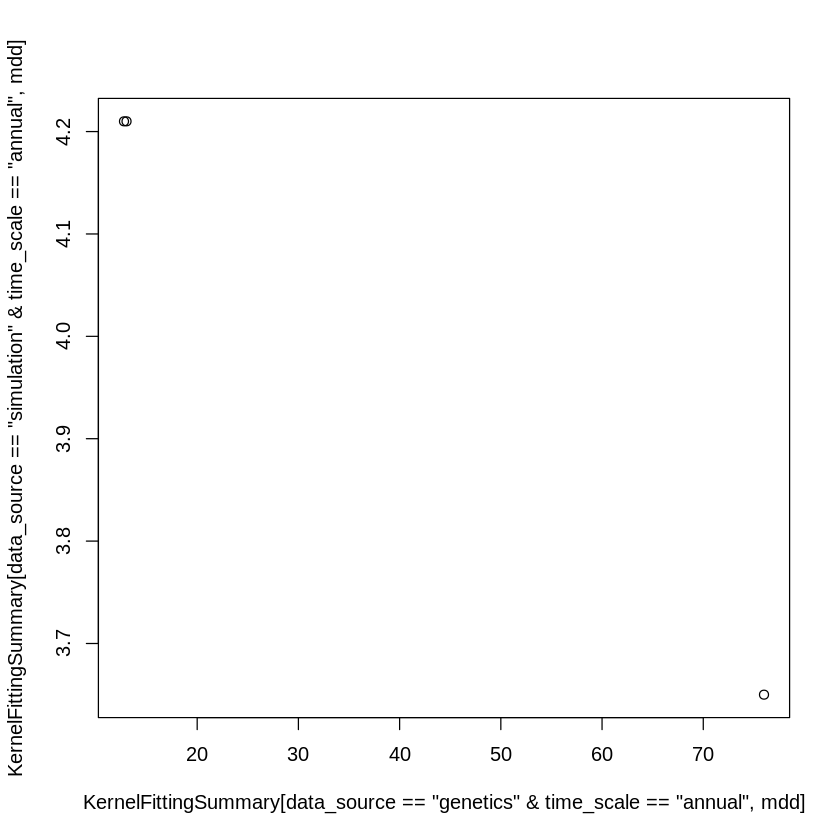

In [25]:
#cor.test(KernelFittingSummary[data_source=="simulation" & time_scale=="annual", mdd], KernelFittingSummary[data_source=="genetics" & time_scale=="annual", mdd], method="spearman" )


In [23]:
cor.test(KernelFittingSummary[data_source=="simulation"& time_scale=="annual", mdd], PubKernels[time_scale=="annual", mdd], method="spearman" )

Warning message in cor.test.default(KernelFittingSummary[data_source == "simulation" & :
“Cannot compute exact p-value with ties”


	Spearman's rank correlation rho

data:  KernelFittingSummary[data_source == "simulation" & time_scale ==  and PubKernels[time_scale == "annual", mdd]    "annual", mdd] and PubKernels[time_scale == "annual", mdd]
S = 7.4641, p-value = 0.3333
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.8660254 


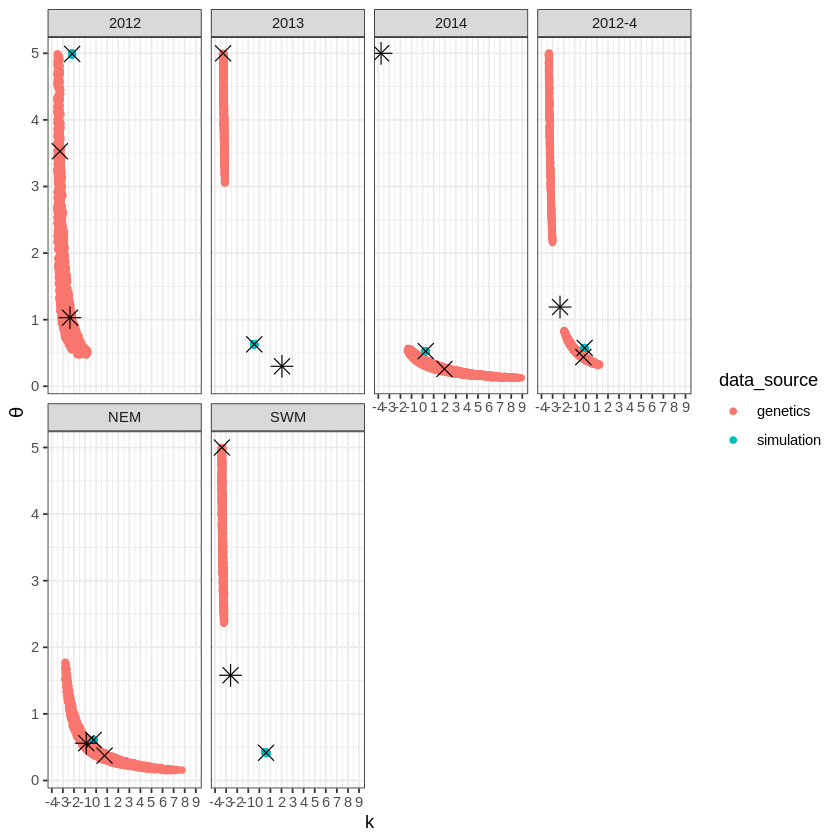

In [76]:
GenPlusSimKernels95CI$time_id <- factor(GenPlusSimKernels95CI$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
#PubKernels$time_id <- factor(PubKernels$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))

surface <- ggplot() +
        geom_point(data=GenPlusSimKernels95CI[, .SD[sample(.N, 1000, prob=max(log_like)/log_like)], by = c("time_id", "data_source")], aes(x=k_eval, y=theta_eval, color=data_source, fill=data_source)) +
        geom_point(data=KernelFittingSummary, aes(x=k, y=theta),shape=4, size=4) + #, color=data_source, fill=data_source
        #geom_point(data=PubKernels, aes(x=best_k, y=best_theta),shape=8, size=4) + #, color=data_source, fill=data_source
        scale_x_continuous(breaks = seq(-10, 10, by = 1)) + #, expand = c(0, 0)
        scale_y_continuous(breaks = seq(0, 6, by = 1)) +#, expand = c(0, 0)
        theme(axis.text.x = element_text(size=12, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
        axis.text.y =  element_text(size=12, color="black", family="Helvetica"),
        axis.title.y =  element_text(size=14, color="black", family="Helvetica"), 
        axis.title.x =  element_text(size=14, color="black", family="Helvetica")) +
        xlab("k") + ylab(expression(theta)) +
        theme_bw() + 
        facet_wrap(~ time_id, ncol = 4) 
#surface_grid <- surface +facet_grid(cols=vars(time_id), fig.width=6)
surface
#ggsave(filename="SurfaceGridWithPubKernels.png",  plot=surface, path="~/oceanography/script_output/plots/", units="in", width=8, height=6)


In [29]:
#read in sampled kernels for plotting KERNELS
GenPlusSimKernels95CISamp <- fread("~/oceanography/script_output/KernelFits/GenPlusSimKernels95CISummaryStatsSampForPlots.csv")

In [ ]:
#plot the actual dispersal kernels

In [23]:
#make a df with the pdf values at each distance to plot for each kernel fit, use 200 kernel fits not 1000

ToPlot <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(GenPlusSimKernels95CISamp))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
              do.call("rbind", replicate(length(seq(0, 80, 0.1)), GenPlusSimKernels95CISamp[, .(time_id, data_source, k_eval, theta_eval, group=.I)], simplify = FALSE))) #add the group number for plotting

nrow(ToPlot)==nrow(GenPlusSimKernels95CISamp)*length(seq(0, 80, 0.1)) #should be true

#add a column for pdf value at that distance

ToPlot[, pdf := predicted_disp(k=k_eval, theta=theta_eval, d=dist_eval),
                      by=c("k_eval", "theta_eval", "dist_eval")]
BestFits <- cbind(data.table(dist_eval=rep(seq(0, 80, 0.1), nrow(KernelFittingSummary))), #each time_id/data_source combo will need a row for each distance to evaluate, so make that for distances
            do.call("rbind", replicate(length(seq(0, 80, 0.1)), KernelFittingSummary[, .(time_id, data_source, k, theta, group=.I)], simplify = FALSE)))[ #add the group number for plotting
            , pdf := predicted_disp(k=k, theta=theta, d=dist_eval),
                      by=c("k", "theta", "dist_eval")]


[1] TRUE

In [12]:
 head(ToPlot)

dist_eval,time_id,data_source,k_eval,theta_eval,group,pdf
0.0,2012,genetics,-2.528280,1.0050352,1,0.07996469
0.1,2012,genetics,-3.229406,4.7003776,2,0.04326334
0.2,2012,genetics,-3.502774,2.0673327,3,0.03399478
0.3,2012,genetics,-3.111844,0.9959557,4,0.04384229
0.4,2012,genetics,-2.414967,1.1049093,5,0.09044665
0.5,2012,genetics,-2.637344,1.4953263,6,0.07868657


Warning message:
“Removed 78 row(s) containing missing values (geom_path).”Warning message:
“Removed 9 row(s) containing missing values (geom_path).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 78 row(s) containing missing values (geom_path).”Warning message:
“Removed 9 row(s) containing missing values (geom_path).”

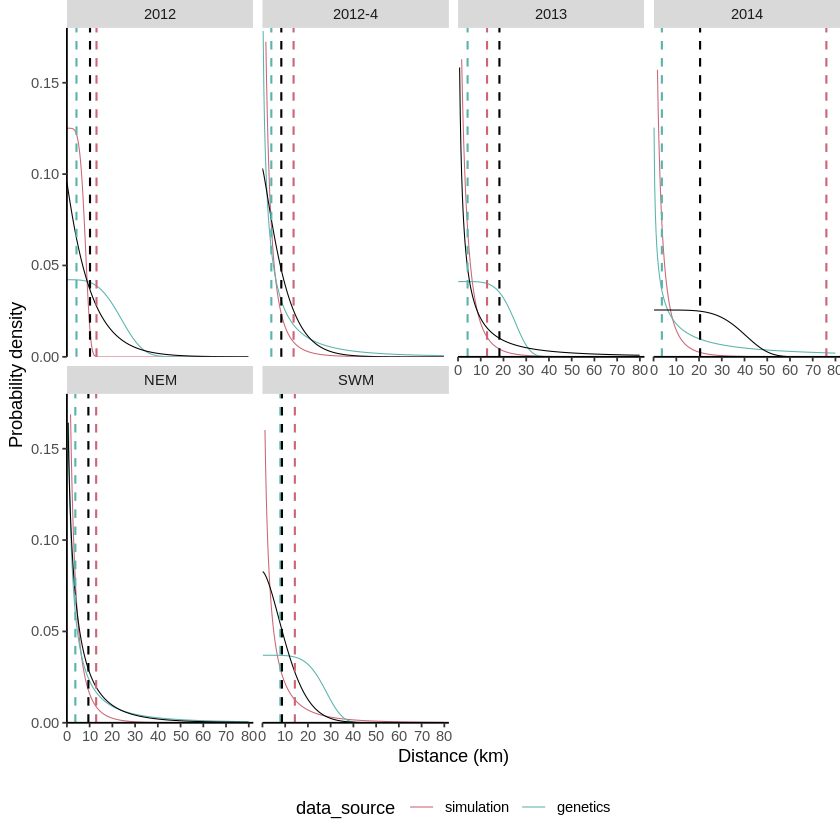

In [120]:
ToPlot$time_id <- factor(ToPlot$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
BestFits$time_id <- factor(BestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
KernelFittingSummary$time_id <- factor(KernelFittingSummary$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))
#PubBestFits$time_id <- factor(PubBestFits$time_id, levels=c("2012", "2013", "2014", "2012-4", "NEM", "SWM"))

#fix the levels for data source so colors are consistent between graphs
ToPlot$data_source <- factor(ToPlot$data_source, levels=c("simulation", "genetics"))
BestFits$data_source <- factor(BestFits$data_source, levels=c("simulation", "genetics"))
KernelFittingSummary$data_source <- factor(KernelFittingSummary$data_source, levels=c("simulation", "genetics"))

kernels <- ggplot() + 
    #geom_line(data= ToPlot, aes(x=dist_eval, y=pdf, color=data_source, group=group), size=.6, alpha=0.25)+
    #geom_line(data=BestFits, aes(x=dist_eval, y=pdf, group=group), color="black", size=0.1) +
    geom_line(data=BestFits, aes(x=dist_eval, y=pdf, color=data_source, group=group), size=0.3) + #for pub kernels plot
    #geom_line(data=PubBestFits, aes(x=dist_eval, y=pdf, group=group), color="black", size=0.3) +  #for pub kernels plot
      #geom_area(data=kernel15, aes(x=dist, y=norm_pdf, fill=as.factor(median)), alpha=0.1)+
    #annotate("text", x =Inf, y = 0.17, vjust=1, hjust=1, label = "2014", size=6)+#8 for publication, 15 for presentation, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##annotate("text", x =MDD15, y = 0.01, vjust=1, hjust=1, label = "mu", color="deepskyblue2", size=15, family="Helvetica", parse=T)+#, fontface="bold", col="deepskyblue2") + #for 15 year  fontface="bold", col="deepskyblue2"
    ##scale_fill_manual(values= c("whitesmoke", "cadetblue3")) +
    ##scale_color_manual(values= c("whitesmoke", "cadetblue3")) +
    #geom_line(color="black", size=.6) +  
    geom_vline(data=KernelFittingSummary[data_source=="genetics"], aes(xintercept = mdd), linetype="dashed", color = "#CC6677", size=0.6) + 
    geom_vline(data=KernelFittingSummary[data_source=="simulation"], aes(xintercept = mdd), linetype="dashed", color = "#5ab4ac", size=0.6) +
    geom_vline(data=PubKernels, aes(xintercept = mdd), linetype="dashed", color = "black", size=0.6) +  #for pub kernels plot
    theme(legend.position = "bottom",
    legend.key=element_blank(),
    #axis.title.y=element_blank(),
    #axis.title.x=element_blank(),
    #plot.background = element_rect(colour = "black", size = 1),
    #axis.text.x =  element_text(size=15, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    #axis.text.y =  element_blank(), #element_text(size=15, color="black", family="Helvetica"), 
    panel.grid.major = element_blank(),
    plot.margin=unit(c(0,0,0.2,0.2),"cm"),#,
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Distance (km)") + #
    ylab("Probability density") + 
    #guides(fill=FALSE)+
    scale_x_continuous(limits = c(0,82), expand = c(0, 0), breaks=c(seq(0, 80, 10))) +
    scale_y_continuous(expand = c(0,0), limits = c(0,.18)) + 
    scale_colour_manual(name = "data_source",values = c("#CC6677","#5ab4ac"))+
        facet_wrap(~ time_id, ncol = 4) 
kernels
#Facet <- test + facet_grid(.~time_id) +
#  theme(aspect.ratio = 1) #+ ggtitle("2014 Simulations, red line genetics")
#Facet

#ggsave(filename="GenPlusSimKernelsWithPubKernels.png", plot= kernels, path="~/oceanography/script_output/plots/" )


Warning message:
“Removed 627 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 627 rows containing non-finite values (stat_ydensity).”

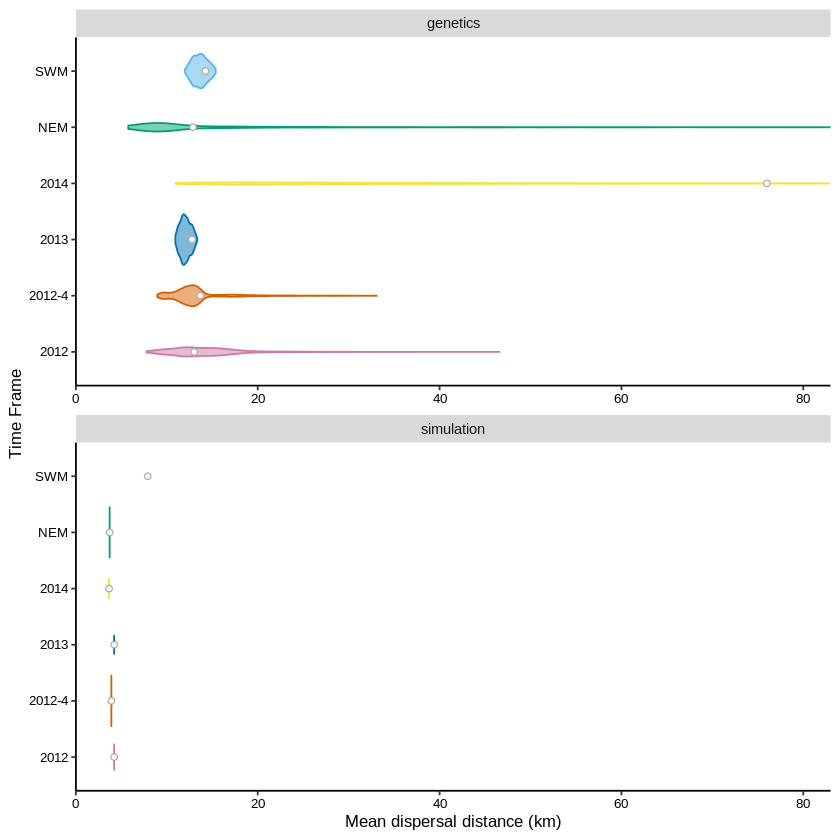

In [30]:
#panel plot of the metrics of interest
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

mdd_violin <- ggplot() +
    geom_violin(data=GenPlusSimKernels95CISamp, aes(x=time_id, y=mdd, color=time_id, fill=time_id), alpha=0.5) +
    geom_point(data=KernelFittingSummary, aes(x=time_id, y=mdd), fill="snow",color="darkgray", shape=21) +
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Time Frame") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)+
        facet_wrap(~ data_source, ncol = 1, scales = "free") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
#ggsave(filename="GenPlusSimMDDPanel.png", plot= mdd_violin, path="~/oceanography/script_output/plots/" )


Saving 6.67 x 6.67 in image


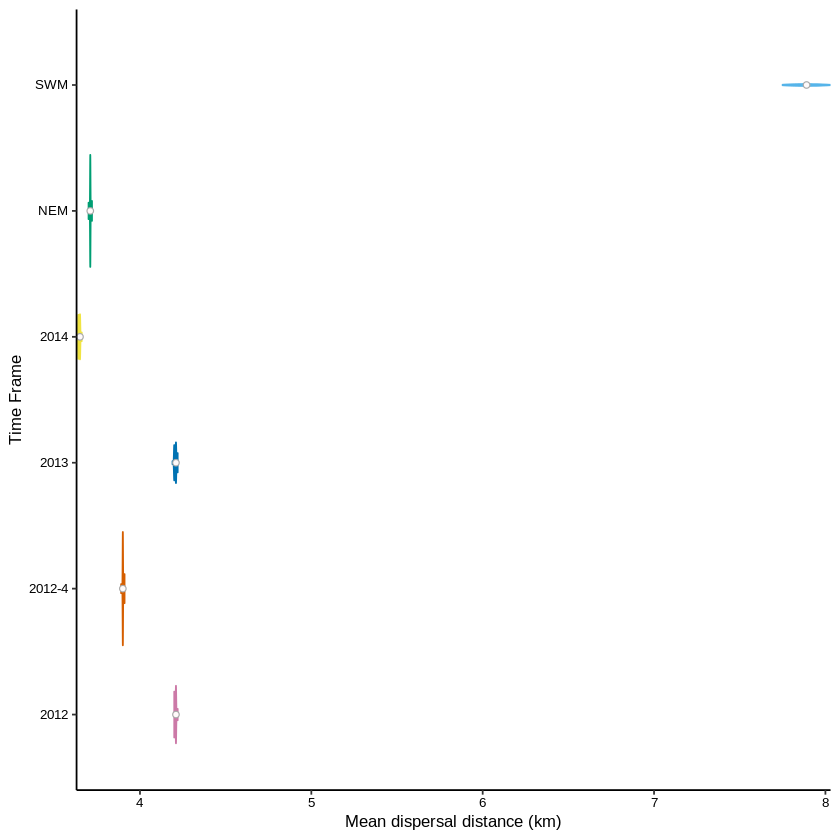

In [32]:
#panel plot of the metrics of interest
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

sim_mdd_violin <- ggplot() +
    geom_violin(data=GenPlusSimKernels95CISamp[data_source=="simulation"], aes(x=time_id, y=mdd, color=time_id, fill=time_id), alpha=0.5) +
    geom_point(data=KernelFittingSummary[data_source=="simulation"], aes(x=time_id, y=mdd), fill="snow",color="darkgray", shape=21) +
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Time Frame") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)#+
        #facet_wrap(~ data_source, ncol = 1, scales = "free") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
sim_mdd_violin
ggsave(filename="SimMDD.png", plot= sim_mdd_violin, path="~/oceanography/script_output/plots/" )


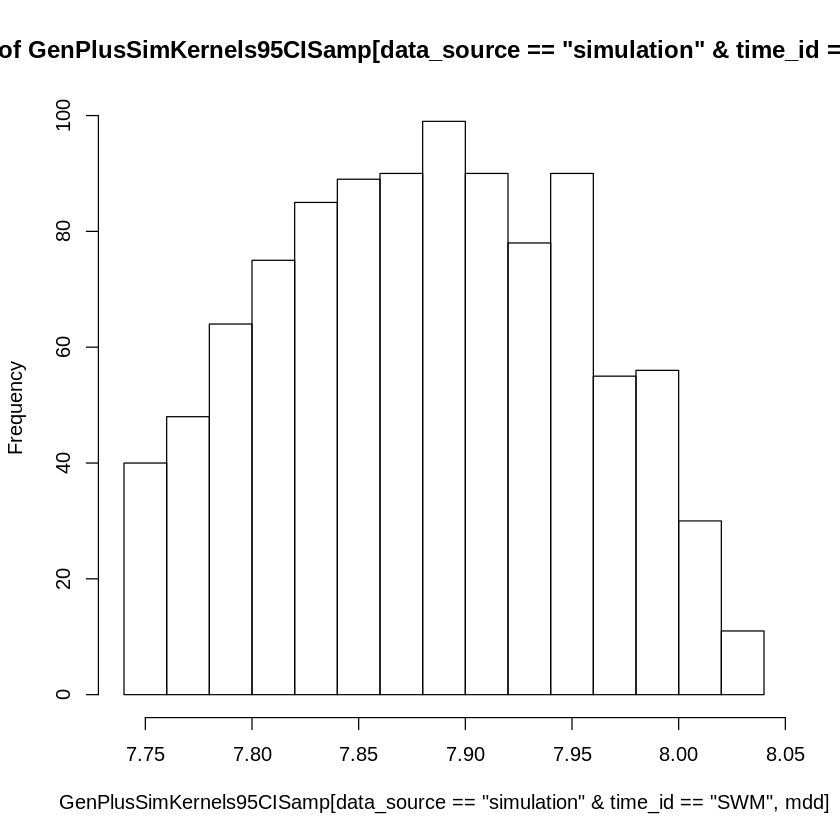

In [33]:
hist(GenPlusSimKernels95CISamp[data_source=="simulation" & time_id=="SWM", mdd])

Warning message:
“Removed 55 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 55 rows containing non-finite values (stat_ydensity).”

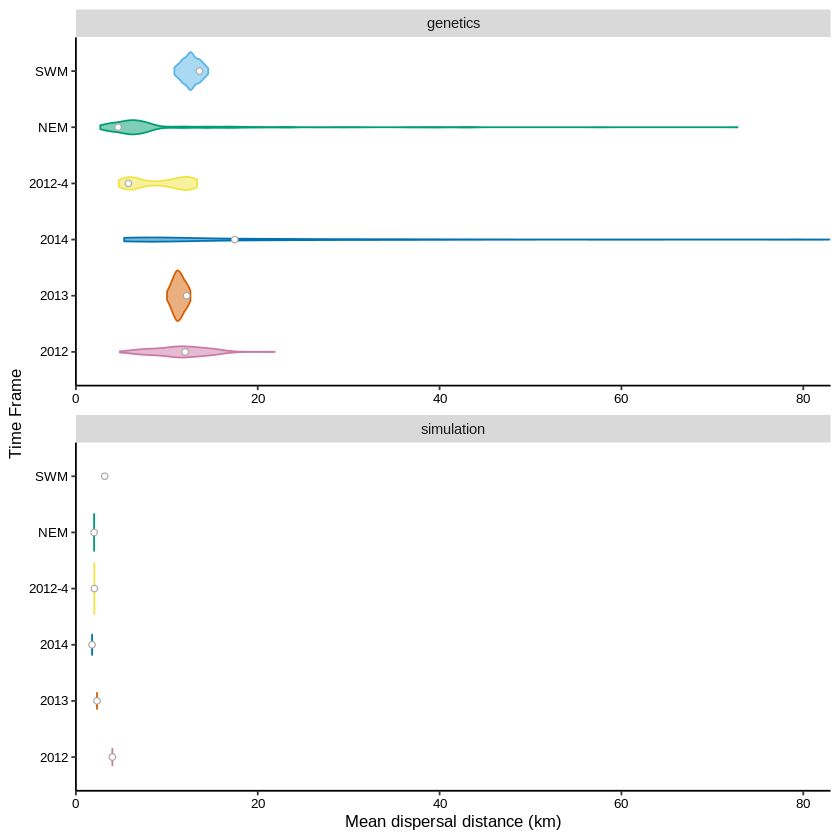

In [61]:
#panel plot of the metrics of interest
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

med_violin <- ggplot() +
    geom_violin(data=GenPlusSimKernels95CISamp, aes(x=time_id, y=med, color=time_id, fill=time_id), alpha=0.5) +
    geom_point(data=KernelFittingSummary, aes(x=time_id, y=med), fill="snow",color="darkgray", shape=21) +
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Time Frame") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)+
        facet_wrap(~ data_source, ncol = 1, scales = "free") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
med_violin
ggsave(filename="GenPlusSimMedianPanel.png", plot= med_violin, path="~/oceanography/script_output/plots/" )


In [11]:
#plot the variation (CV) to see if the scale of variation matches genetics and simulations
Variation <- KernelFittingSummary[time_scale != "interannual",.( sd_k=round(sd(k), 2), cv_theta=round(cv(theta),2), cv_mdd=round(cv(mdd),2), cv_med=round(cv(med),2), cv_dist90=round(cv(dist90),2)), by=c("data_source", "time_scale")]   
Variation

#fwrite(AnnualVariation, "~/oceanography/script_output/KernelFits/VariationSummary.csv")

data_source,time_scale,sd_k,cv_theta,cv_mdd,cv_med,cv_dist90
simulation,annual,1.25,1.24,0.08,0.43,0.14
simulation,season,0.58,0.26,0.51,0.32,0.52
genetics,annual,3.03,0.83,1.07,0.22,1.18
genetics,season,2.93,1.22,0.07,0.69,0.14


time_scale,sd_k,cv_theta,cv_mdd,cv_med,data_source
annual,3.02,1.20,0.33,0.74,pub_kernels
season,1.21,0.67,0.07,0.25,pub_kernels


In [110]:
str(rbind(Variation[,-"cv_dist90"], PubVariation))

Classes ‘data.table’ and 'data.frame':	6 obs. of  6 variables:
 $ data_source: chr  "simulation" "simulation" "genetics" "genetics" ...
 $ time_scale : chr  "annual" "season" "annual" "season" ...
 $ sd_k       : num  1.25 0.58 3.03 2.93 3.02 1.21
 $ cv_theta   : num  1.24 0.26 0.83 1.22 1.2 0.67
 $ cv_mdd     : num  0.08 0.51 1.07 0.07 0.33 0.07
 $ cv_med     : num  0.43 0.32 0.22 0.69 0.74 0.25
 - attr(*, ".internal.selfref")=<externalptr> 


In [12]:
ToPlotVariation <- Variation#melt(rbind(Variation[,-"cv_dist90"], PubVariation), id.vars=c("data_source","time_scale"))
#head(ToPlotVariation)

In [13]:
ToPlotVariation$data_source <- factor(ToPlotVariation$data_source, levels=c("simulation", "genetics"))
CVPlot <- ggplot(data=ToPlotVariation[variable !="sd_k"], aes(x=variable, y=value, color=data_source)) +
    geom_point(size=2) +
    ylab("coefficient of varition") +
    scale_colour_manual(name = "data_source",values = c("#CC6677","#5ab4ac", "black"))+
        facet_wrap(~ time_scale, ncol = 2) 

   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlot

#ggsave(filename="SimulationGeneticFitsCVComparisonWithPubKernels.png", plot= CVPlot, path="~/oceanography/script_output/plots/" )


ERROR: Error in .checkTypos(e, names(x)): Object 'variable' not found amongst data_source, time_scale, sd_k, cv_theta, cv_mdd and 2 more


In [19]:
AnnualMonsoonKernels

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,kurtosis
annual_monsoon,NEM2011,-1.75309,1.30265,4.26,3.24,9.39,-1045881.8,simulation,1.3273615
annual_monsoon,NEM2012,-1.73326,1.26304,4.30,3.24,9.52,-1120211.9,simulation,1.4752248
annual_monsoon,NEM2013,-1.85889,1.35246,4.58,3.52,10.04,-1028977.7,simulation,1.1603603
annual_monsoon,NEM2014,-1.50649,1.11461,3.92,2.83,8.86,-901086.4,simulation,2.1887464
annual_monsoon,SWM2011,-2.14126,1.60872,5.36,4.31,11.41,-371065.6,simulation,0.5362588
annual_monsoon,SWM2012,-1.92231,1.47343,4.57,3.59,9.86,-141712.1,simulation,0.8248345
annual_monsoon,SWM2013,-1.92912,1.40630,4.76,3.70,10.37,-195363.6,simulation,1.0000850
annual_monsoon,SWM2014,-2.08679,1.56256,5.17,4.13,11.06,-197547.8,simulation,0.6263800
annual,2011,-1.87313,1.38616,4.56,3.52,9.94,-1419852.1,simulation,1.0577945


In [16]:
#relationship with enso?
#annual&monsoon fits and 2011 as well
AnnualMonsoonKernels <- fread(file="~/oceanography/script_output/KernelFits/summary_tables/SimulationKernelFitsAnnualMonsoon.csv")[, kurtosis := ((gamma(5/theta)*gamma(1/theta))/gamma(3/theta)^2)-3, by=c("time_id", "data_source", "theta")]   
enso <- fread(file="~/oceanography/empirical_data/environment/enso/meiv2.csv")
setnames(enso, "YEAR", "year")

In [46]:
ENSO <- melt(enso, id.vars="year", variable.name = "month", value="mei_index")[year %in% c(2011, 2012, 2013, 2014)][
    , monsoon := ifelse(month %in% c("ND", "DJ", "JF", "FM", "MA", "MJ"), "NEM", "SWM")][
    , annual_avg_mei := mean(mei_index), by=c("year")][, annual_monsoon_avg_mei := mean(mei_index), by=c("year", "monsoon")][, monsoon_avg_mei := mean(mei_index), by=c("monsoon")][ 
    , annual_monsoon_max_mei := max(mei_index), by=c("year","monsoon")][
    , annual_monsoon_min_mei := min(mei_index), by=c("year","monsoon")]
ENSO[,monsoon_annual := paste(ENSO$monsoon, ENSO$year, sep="")] #to match the time_id format of annual&monsoon fits

In [20]:
AnnualKernels <- rbind(AnnualMonsoonKernels[time_id==2011], KernelFittingSummary[data_source=="simulation"&time_id %in% c(2012, 2013, 2014)], fill=TRUE)[, kurtosis := ((gamma(5/theta)*gamma(1/theta))/gamma(3/theta)^2)-3, by=c("time_id", "data_source", "theta")]   

AnnualKernelsENSO <- left_join(AnnualKernels[time_id %in% c(2011,2012, 2013, 2014)][, time_id := as.numeric(time_id)], unique(ENSO, by=c("year", "monsoon"))[, -c("month", "monsoon_annual")], by=c(time_id="year"))
AnnualKernelsENSO


time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,kurtosis,...,upper_mdd,lower_med,upper_med,lower_dist90,upper_dist90,mei_index,monsoon,annual_avg_mei,annual_monsoon_avg_mei,monsoon_avg_mei
annual,2011,-1.87313,1.38616,4.56,3.52,9.94,-1419852,simulation,1.0577945,...,NA,NA,NA,NA,NA,-1.83,NEM,-1.34000000,-1.55166667,-0.6433333
annual,2011,-1.87313,1.38616,4.56,3.52,9.94,-1419852,simulation,1.0577945,...,NA,NA,NA,NA,NA,-1.29,SWM,-1.34000000,-1.12833333,-0.4045833
annual,2012,-2.16400,4.99100,4.21,4.01,7.88,NA,simulation,-0.9291035,...,4.22,4.00,4.02,7.86,7.90,-1.08,NEM,-0.32000000,-0.52000000,-0.6433333
annual,2012,-2.16400,4.99100,4.21,4.01,7.88,NA,simulation,-0.9291035,...,4.22,4.00,4.02,7.86,7.90,-0.35,SWM,-0.32000000,-0.12000000,-0.4045833
annual,2013,-0.46100,0.63000,4.21,2.32,10.38,NA,simulation,10.8966730,...,4.23,2.31,2.33,10.34,10.43,-0.05,NEM,-0.41166667,-0.36000000,-0.6433333
annual,2013,-0.46100,0.63000,4.21,2.32,10.38,NA,simulation,10.8966730,...,4.23,2.31,2.33,10.34,10.43,-0.71,SWM,-0.41166667,-0.46333333,-0.4045833
annual,2014,0.28300,0.52800,3.65,1.78,9.16,NA,simulation,18.6209801,...,3.67,1.75,1.79,8.97,9.22,-0.51,NEM,-0.02416667,-0.14166667,-0.6433333
annual,2014,0.28300,0.52800,3.65,1.78,9.16,NA,simulation,18.6209801,...,3.67,1.75,1.79,8.97,9.22,-0.18,SWM,-0.02416667,0.09333333,-0.4045833


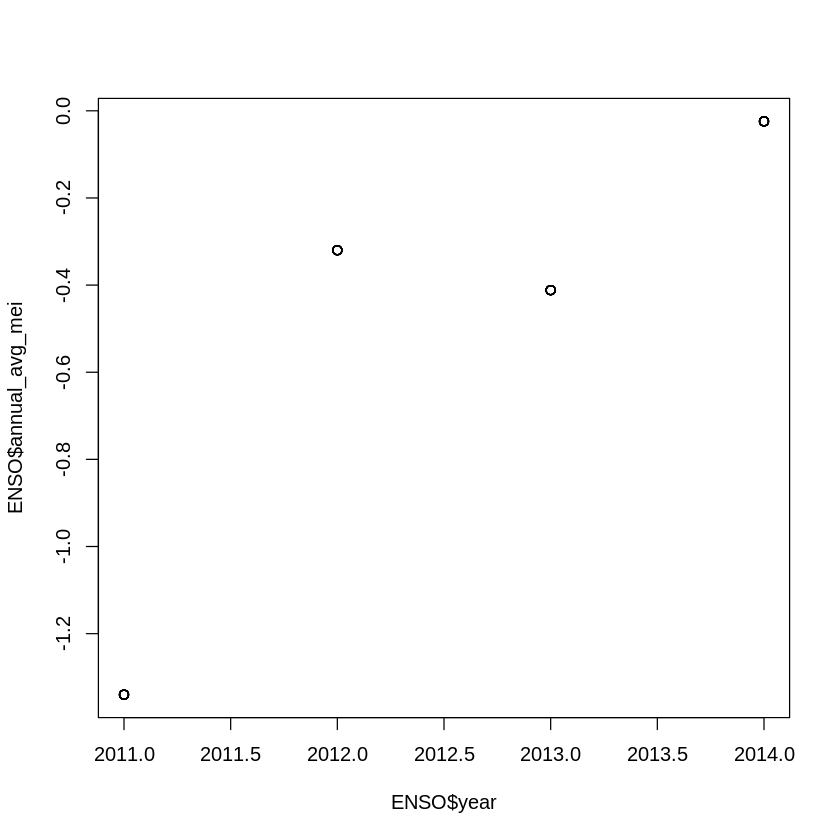

In [144]:
plot(ENSO$year, ENSO$annual_avg_mei)

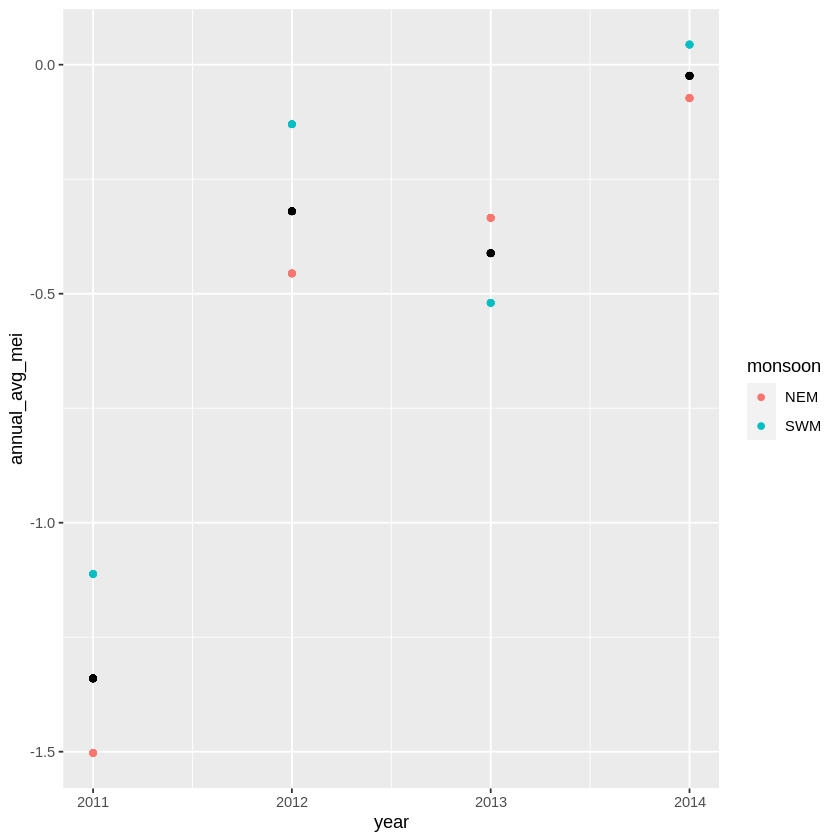

In [76]:
ggplot() +
    geom_point(data=ENSO, aes(x=year, y=annual_avg_mei))+
    #geom_point(data=ENSO, aes(x=year, y=mei_index))+
    geom_point(data=ENSO, aes(x=year, y=annual_monsoon_avg_mei, color=monsoon))

In [184]:
AnnualKernelsENSO[data_source=="simulation", .(time_id, theta, mdd, annual_avg_mei)]

time_id,theta,mdd,annual_avg_mei
2011,1.38616,4.56,-1.34000000
2012,4.99100,4.21,-0.32000000
2013,0.63000,4.21,-0.41166667
2014,0.52800,3.65,-0.02416667


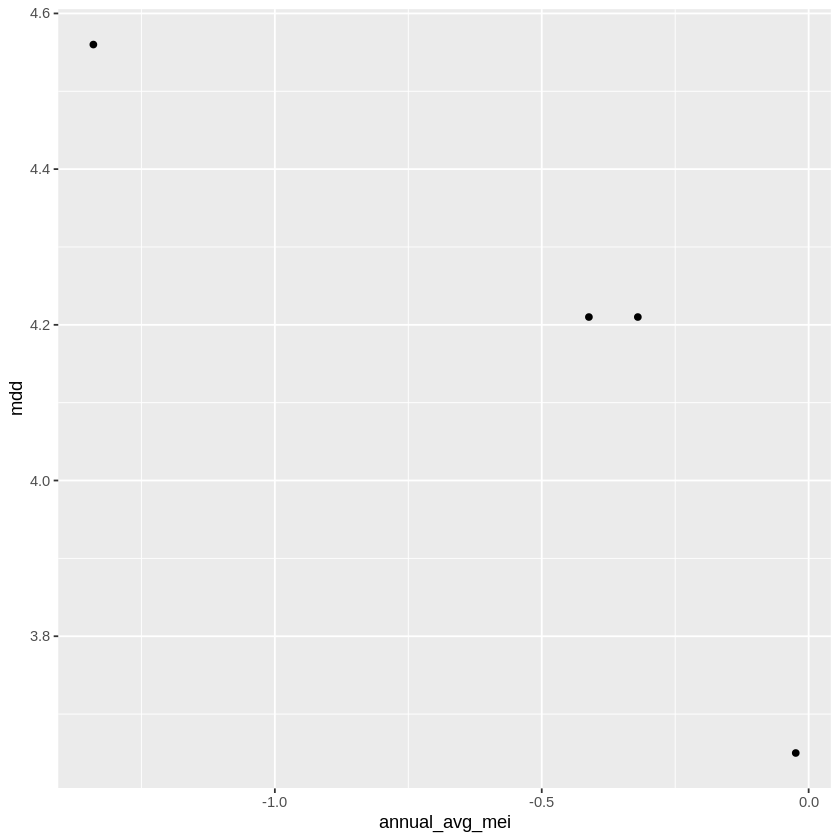

In [185]:
ggplot() +
    geom_point(data=AnnualKernelsENSO[data_source=="simulation"], aes(x=annual_avg_mei, y=mdd))

In [57]:
test_mod <- lm(data=unique(AnnualKernelsENSO[data_source=="simulation"], by="time_id"), mdd ~ annual_avg_mei+time_id) #no this is wrong need to remove double counts for each year
unique(AnnualKernelsENSO[data_source=="simulation"], by="time_id")
summary(test_mod)
#plot(test_mod)

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,kurtosis,...,upper_mdd,lower_med,upper_med,lower_dist90,upper_dist90,mei_index,monsoon,annual_avg_mei,annual_monsoon_avg_mei,monsoon_avg_mei
annual,2011,-1.87313,1.38616,4.56,3.52,9.94,-1419852,simulation,1.0577945,...,NA,NA,NA,NA,NA,-1.83,NEM,-1.34000000,-1.5516667,-0.6433333
annual,2012,-2.16400,4.99100,4.21,4.01,7.88,NA,simulation,-0.9291035,...,4.22,4.00,4.02,7.86,7.90,-1.08,NEM,-0.32000000,-0.5200000,-0.6433333
annual,2013,-0.46100,0.63000,4.21,2.32,10.38,NA,simulation,10.8966730,...,4.23,2.31,2.33,10.34,10.43,-0.05,NEM,-0.41166667,-0.3600000,-0.6433333
annual,2014,0.28300,0.52800,3.65,1.78,9.16,NA,simulation,18.6209801,...,3.67,1.75,1.79,8.97,9.22,-0.51,NEM,-0.02416667,-0.1416667,-0.6433333



Call:
lm(formula = kurtosis ~ as.factor(time_id), data = unique(AnnualKernelsENSO[data_source == 
    "simulation"], by = "time_id"))

Residuals:
ALL 4 residuals are 0: no residual degrees of freedom!

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)
(Intercept)               1.058         NA      NA       NA
as.factor(time_id)2012   -1.987         NA      NA       NA
as.factor(time_id)2013    9.839         NA      NA       NA
as.factor(time_id)2014   17.563         NA      NA       NA

Residual standard error: NaN on 0 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 3 and 0 DF,  p-value: NA


In [47]:
#what if we divide up the monsoons of each year?
AnnualMonsoonENSO <- unique(left_join(AnnualMonsoonKernels[time_id != 2011], ENSO, by=c(time_id="monsoon_annual")), by="time_id") 

In [48]:
AnnualMonsoonENSO

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,kurtosis,year,month,mei_index,monsoon,annual_avg_mei,annual_monsoon_avg_mei,monsoon_avg_mei,annual_monsoon_max_mei,annual_monsoon_min_mei
annual_monsoon,NEM2011,-1.75309,1.30265,4.26,3.24,9.39,-1045881.8,simulation,1.3273615,2011,DJ,-1.83,NEM,-1.34000000,-1.55166667,-0.6433333,-1.08,-1.83
annual_monsoon,NEM2012,-1.73326,1.26304,4.30,3.24,9.52,-1120211.9,simulation,1.4752248,2012,DJ,-1.08,NEM,-0.32000000,-0.52000000,-0.6433333,-0.07,-1.08
annual_monsoon,NEM2013,-1.85889,1.35246,4.58,3.52,10.04,-1028977.7,simulation,1.1603603,2013,DJ,-0.05,NEM,-0.41166667,-0.36000000,-0.6433333,-0.05,-1.18
annual_monsoon,NEM2014,-1.50649,1.11461,3.92,2.83,8.86,-901086.4,simulation,2.1887464,2014,DJ,-0.51,NEM,-0.02416667,-0.14166667,-0.6433333,0.34,-0.51
annual_monsoon,SWM2011,-2.14126,1.60872,5.36,4.31,11.41,-371065.6,simulation,0.5362588,2011,AM,-1.29,SWM,-1.34000000,-1.12833333,-0.4045833,-0.86,-1.37
annual_monsoon,SWM2012,-1.92231,1.47343,4.57,3.59,9.86,-141712.1,simulation,0.8248345,2012,AM,-0.35,SWM,-0.32000000,-0.12000000,-0.4045833,0.30,-0.35
annual_monsoon,SWM2013,-1.92912,1.40630,4.76,3.70,10.37,-195363.6,simulation,1.0000850,2013,AM,-0.71,SWM,-0.41166667,-0.46333333,-0.4045833,-0.16,-0.85
annual_monsoon,SWM2014,-2.08679,1.56256,5.17,4.13,11.06,-197547.8,simulation,0.6263800,2014,AM,-0.18,SWM,-0.02416667,0.09333333,-0.4045833,0.34,-0.18


Saving 6.67 x 6.67 in image


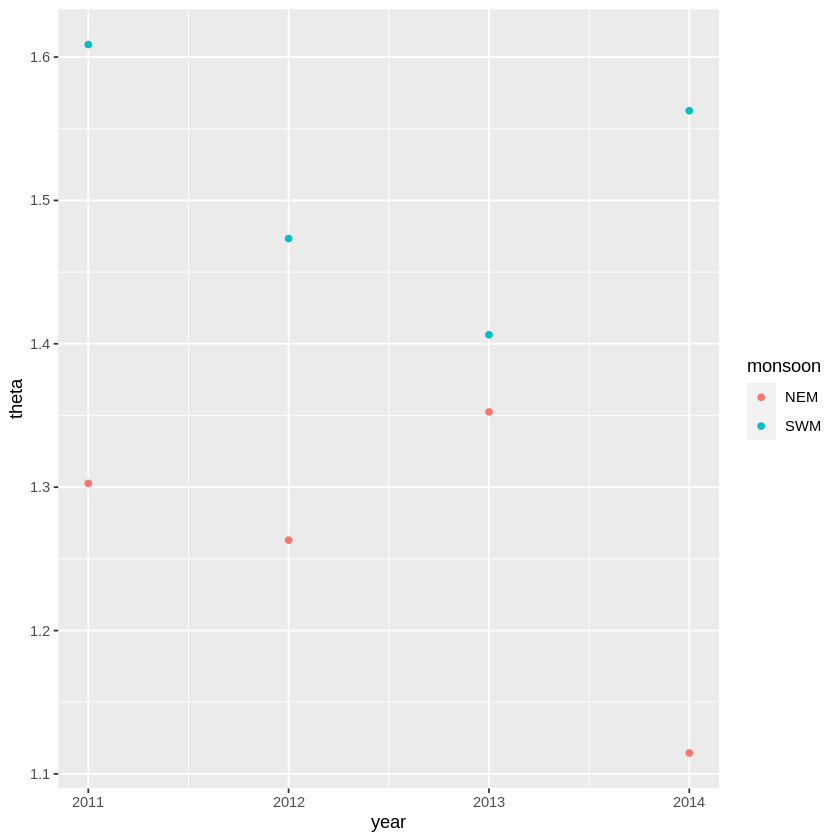

In [60]:
MonsoonTheta <- ggplot() +
    #geom_point(data=AnnualMonsoonENSO, aes(x=year, y=annual_monsoon_avg_mei))+
    #geom_point(data=ENSO, aes(x=year, y=mei_index))+
    geom_point(data=AnnualMonsoonENSO, aes(x=year, y=theta, color=monsoon)) 
MonsoonTheta 
#ggsave(filename="MonsoonThetaAnnual.png", plot= MonsoonTheta, path="~/oceanography/script_output/plots/" )


Saving 6.67 x 6.67 in image


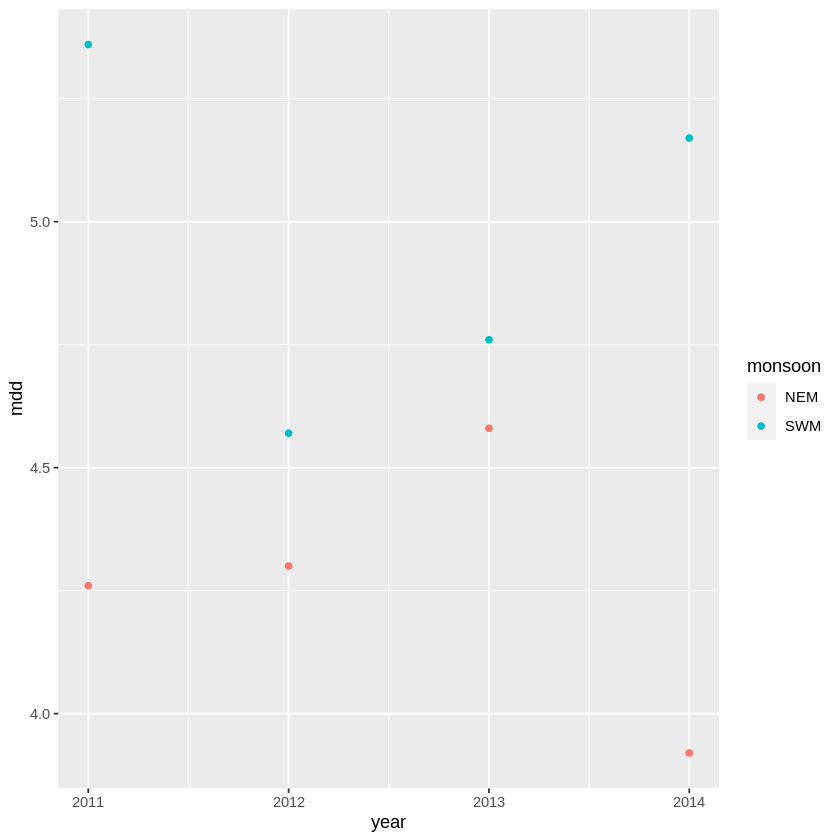

In [62]:
MonsoonMDD <- ggplot() +
    #geom_point(data=AnnualMonsoonENSO, aes(x=year, y=annual_monsoon_avg_mei))+
    #geom_point(data=ENSO, aes(x=year, y=mei_index))+
    geom_point(data=AnnualMonsoonENSO, aes(x=year, y=mdd, color=monsoon)) 
MonsoonMDD 
ggsave(filename="MonsoonMDDAnnual.png", plot= MonsoonMDD, path="~/oceanography/script_output/plots/" )


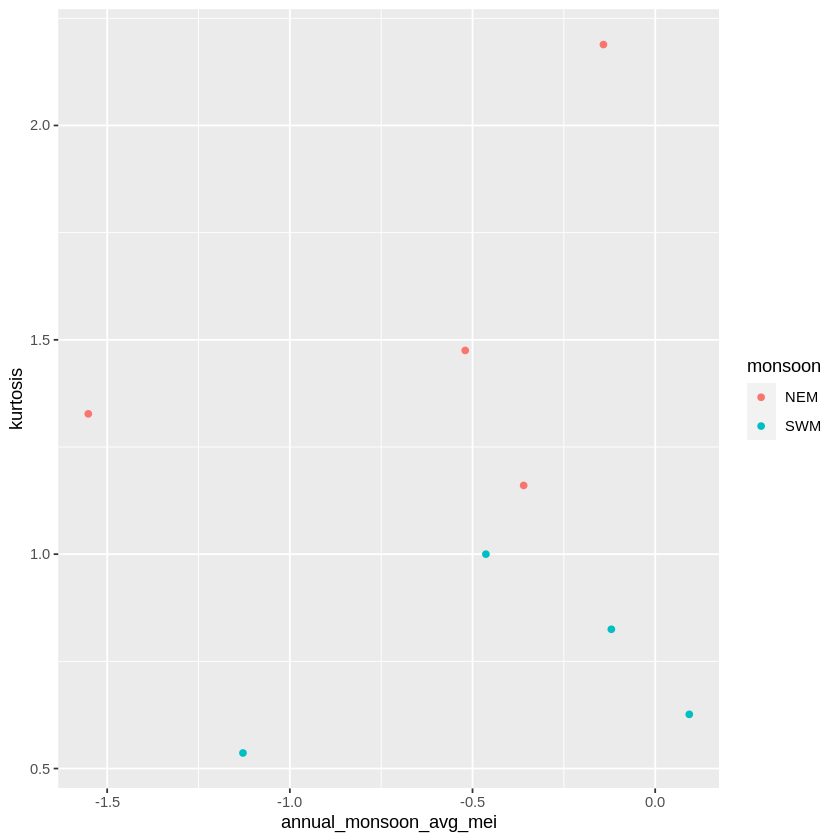

In [25]:
ggplot() +
    #geom_point(data=AnnualMonsoonENSO, aes(x=year, y=annual_monsoon_avg_mei))+
    #geom_point(data=ENSO, aes(x=year, y=mei_index))+
    geom_point(data=AnnualMonsoonENSO, aes(x=annual_monsoon_avg_mei, y=kurtosis, color=monsoon))

In [45]:
AnnualMonsoonENSO

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source,kurtosis,year,month,mei_index,monsoon,annual_avg_mei,annual_monsoon_avg_mei,monsoon_avg_mei,monsoon_max_mei,monsoon_min_mei
annual_monsoon,NEM2011,-1.75309,1.30265,4.26,3.24,9.39,-1045881.8,simulation,1.3273615,2011,DJ,-1.83,NEM,-1.34000000,-1.55166667,-0.6433333,-1.08,-1.83
annual_monsoon,NEM2012,-1.73326,1.26304,4.30,3.24,9.52,-1120211.9,simulation,1.4752248,2012,DJ,-1.08,NEM,-0.32000000,-0.52000000,-0.6433333,-0.07,-1.08
annual_monsoon,NEM2013,-1.85889,1.35246,4.58,3.52,10.04,-1028977.7,simulation,1.1603603,2013,DJ,-0.05,NEM,-0.41166667,-0.36000000,-0.6433333,-0.05,-1.18
annual_monsoon,NEM2014,-1.50649,1.11461,3.92,2.83,8.86,-901086.4,simulation,2.1887464,2014,DJ,-0.51,NEM,-0.02416667,-0.14166667,-0.6433333,0.34,-0.51
annual_monsoon,SWM2011,-2.14126,1.60872,5.36,4.31,11.41,-371065.6,simulation,0.5362588,2011,AM,-1.29,SWM,-1.34000000,-1.12833333,-0.4045833,-0.86,-1.37
annual_monsoon,SWM2012,-1.92231,1.47343,4.57,3.59,9.86,-141712.1,simulation,0.8248345,2012,AM,-0.35,SWM,-0.32000000,-0.12000000,-0.4045833,0.30,-0.35
annual_monsoon,SWM2013,-1.92912,1.40630,4.76,3.70,10.37,-195363.6,simulation,1.0000850,2013,AM,-0.71,SWM,-0.41166667,-0.46333333,-0.4045833,-0.16,-0.85
annual_monsoon,SWM2014,-2.08679,1.56256,5.17,4.13,11.06,-197547.8,simulation,0.6263800,2014,AM,-0.18,SWM,-0.02416667,0.09333333,-0.4045833,0.34,-0.18


In [51]:
test_mod4<- lm(data=AnnualMonsoonENSO, kurtosis ~ annual_monsoon_avg_mei+monsoon)
summary(test_mod4)
test_mod5<- lm(data=AnnualMonsoonENSO, kurtosis ~ annual_monsoon_max_mei)
summary(test_mod5)
test_mod6<- lm(data=AnnualMonsoonENSO, kurtosis ~ annual_monsoon_min_mei)
summary(test_mod6)
test_mod7<- lm(data=AnnualMonsoonENSO, kurtosis ~ monsoon)
summary(test_mod7)
AIC(test_mod4, test_mod5, test_mod6, test_mod7)


Call:
lm(formula = kurtosis ~ annual_monsoon_avg_mei + monsoon, data = AnnualMonsoonENSO)

Residuals:
        1         2         3         4         5         6         7         8 
 0.014593 -0.093270 -0.447795  0.526471 -0.031230  0.007403  0.267758 -0.243932 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.6974     0.2371   7.160 0.000826 ***
annual_monsoon_avg_mei   0.2479     0.2470   1.003 0.361688    
monsoonSWM              -0.8502     0.2557  -3.326 0.020880 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3518 on 5 degrees of freedom
Multiple R-squared:  0.6898,	Adjusted R-squared:  0.5657 
F-statistic: 5.559 on 2 and 5 DF,  p-value: 0.05359



Call:
lm(formula = kurtosis ~ annual_monsoon_max_mei, data = AnnualMonsoonENSO)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.61300 -0.42204 -0.07198  0.32867  0.94936 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)   
(Intercept)              1.1728     0.2088   5.616  0.00136 **
annual_monsoon_max_mei   0.1959     0.3929   0.499  0.63580   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.565 on 6 degrees of freedom
Multiple R-squared:  0.03979,	Adjusted R-squared:  -0.1202 
F-statistic: 0.2486 on 1 and 6 DF,  p-value: 0.6358



Call:
lm(formula = kurtosis ~ annual_monsoon_min_mei, data = AnnualMonsoonENSO)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6264 -0.3398 -0.0665  0.1895  1.0647 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)  
(Intercept)             1.10120    0.41299   2.666   0.0372 *
annual_monsoon_min_mei -0.04485    0.39107  -0.115   0.9124  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.576 on 6 degrees of freedom
Multiple R-squared:  0.002188,	Adjusted R-squared:  -0.1641 
F-statistic: 0.01315 on 1 and 6 DF,  p-value: 0.9124



Call:
lm(formula = kurtosis ~ monsoon, data = AnnualMonsoonENSO)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3776 -0.2106 -0.0916  0.1218  0.6508 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   1.5379     0.1760   8.738 0.000124 ***
monsoonSWM   -0.7910     0.2489  -3.178 0.019124 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.352 on 6 degrees of freedom
Multiple R-squared:  0.6273,	Adjusted R-squared:  0.5652 
F-statistic:  10.1 on 1 and 6 DF,  p-value: 0.01912


,df,AIC
test_mod4,4,10.228111
test_mod5,3,17.267557
test_mod6,3,17.574842
test_mod7,3,9.695995


In [214]:
test_mod1 <- lm(data=AnnualMonsoonENSO, mdd ~ annual_monsoon_avg_mei)
test_mod2 <- lm(data=AnnualMonsoonENSO, mdd ~ annual_monsoon_avg_mei+monsoon)
test_mod3 <- lm(data=AnnualMonsoonENSO, mdd ~ annual_monsoon_avg_mei*monsoon)

AIC(test_mod1, test_mod2, test_mod3)

summary(test_mod2)
summary(test_mod3)
summary(test_mod1)

,df,AIC
test_mod1,3,15.804033
test_mod2,4,9.313995
test_mod3,5,10.781804



Call:
lm(formula = mdd ~ annual_monsoon_avg_mei + monsoon, data = AnnualMonsoonENSO)

Residuals:
       1        2        3        4        5        6        7        8 
-0.16583  0.05684  0.36517 -0.25618  0.26686 -0.34461 -0.21540  0.29316 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)              4.1511     0.2239  18.541  8.4e-06 ***
annual_monsoon_avg_mei  -0.1771     0.2333  -0.759   0.4821    
monsoonSWM               0.7423     0.2415   3.074   0.0277 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3323 on 5 degrees of freedom
Multiple R-squared:  0.654,	Adjusted R-squared:  0.5157 
F-statistic: 4.726 on 2 and 5 DF,  p-value: 0.0704



Call:
lm(formula = mdd ~ annual_monsoon_avg_mei * monsoon, data = AnnualMonsoonENSO)

Residuals:
       1        2        3        4        5        6        7        8 
-0.06309  0.04289  0.33312 -0.31292  0.15478 -0.30054 -0.22450  0.37026 

Coefficients:
                                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)                        4.22386    0.27905  15.137 0.000111 ***
annual_monsoon_avg_mei            -0.06395    0.33189  -0.193 0.856588    
monsoonSWM                         0.60686    0.36720   1.653 0.173743    
annual_monsoon_avg_mei:monsoonSWM -0.26796    0.51084  -0.525 0.627626    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.3593 on 4 degrees of freedom
Multiple R-squared:  0.6763,	Adjusted R-squared:  0.4335 
F-statistic: 2.786 on 3 and 4 DF,  p-value: 0.1738



Call:
lm(formula = mdd ~ annual_monsoon_avg_mei, data = AnnualMonsoonENSO)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.6906 -0.3280 -0.0367  0.2498  0.7380 

Coefficients:
                       Estimate Std. Error t value Pr(>|t|)    
(Intercept)             4.60891    0.25944  17.765 2.04e-06 ***
annual_monsoon_avg_mei -0.01162    0.35229  -0.033    0.975    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.5156 on 6 degrees of freedom
Multiple R-squared:  0.0001813,	Adjusted R-squared:  -0.1665 
F-statistic: 0.001088 on 1 and 6 DF,  p-value: 0.9748


In [210]:
AnnualMonsoonKernels[order(-mdd)]

time_scale,time_id,k,theta,mdd,med,dist90,log_like,data_source
annual_monsoon,SWM2011,-2.14126,1.60872,5.36,4.31,11.41,-371065.6,simulation
annual_monsoon,SWM2014,-2.08679,1.56256,5.17,4.13,11.06,-197547.8,simulation
annual_monsoon,SWM2013,-1.92912,1.40630,4.76,3.70,10.37,-195363.6,simulation
annual_monsoon,NEM2013,-1.85889,1.35246,4.58,3.52,10.04,-1028977.7,simulation
annual_monsoon,SWM2012,-1.92231,1.47343,4.57,3.59,9.86,-141712.1,simulation
annual,2011,-1.87313,1.38616,4.56,3.52,9.94,-1419852.1,simulation
annual_monsoon,NEM2012,-1.73326,1.26304,4.30,3.24,9.52,-1120211.9,simulation
annual_monsoon,NEM2011,-1.75309,1.30265,4.26,3.24,9.39,-1045881.8,simulation
annual_monsoon,NEM2014,-1.50649,1.11461,3.92,2.83,8.86,-901086.4,simulation


In [9]:
#what if we throw out the boundary fits
SimKernels_test <- SimKernels[k!=10 &k!=-10 & theta!=0.15 &theta!= 8]


In [10]:
#make a summary table with means
SimMean <- SimKernels[, lapply(.SD, mean), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale")] #but don't do that for iteration column
StatCol <- "Stat" #make the column to hold the Stat type
SimMean[,(StatCol):="mean"]      

SimMin <- SimKernels[, lapply(.SD, min), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale")]
SimMin[,(StatCol):="min"]   

SimMax <- SimKernels[, lapply(.SD, max), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale")]
SimMax[,(StatCol):="max"]  

SimCVWithin <- SimKernels[, lapply(.SD, cv), by="time_id", #apply the mean function to get means of each column by time_id
             .SDcols = -c("iteration", "time_scale", "k")] #because k is negative sometimes we can't use CV
SimCVWithin[,(StatCol):="cv_within"]

#bind together all Stats into one data.table
Stats <- list(SimMean, SimMin, SimMax, SimCVWithin)
SimSummary <- rbindlist(Stats, use.names=TRUE, fill=TRUE)

#make new column to ID this as a table with summary of SIMULATED data

data_typeCol <- "data_type" #make the column to hold data type
SimSummary[,(data_typeCol):="Sim"]
#fwrite(SimSummary, file="~/oceanography/script_output/KernelFits/SimulationKernelFitsSummary.csv")

In [11]:
head(SimSummary)

time_id,k,theta,mdd,med,dist90,Stat,data_type
2012,-1.1891536,0.7535468,30.539566,8.06433,62.85350,mean,Sim
2013,-2.3319812,2.8584211,9.887545,7.94379,20.84536,mean,Sim
2014,-2.8957345,6.4497388,18.252179,13.85952,36.77048,mean,Sim
2012-4,-0.1968970,0.5243050,9.601646,4.34026,24.12354,mean,Sim
NEM,-0.1767306,0.5556930,9.138671,4.17908,22.91547,mean,Sim
SWM,-3.4311907,2.3282754,2617.288272,2282.45482,5128.05446,mean,Sim


In [30]:
print(test)

ERROR: Error in print(test): object 'test' not found


In [28]:
#read in the empirical data
kernels <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/kernel_fitting_summary.csv") 
setnames(kernels, c("best_k", "best_theta", "MeanDispDist", "MedianDispDist", "Dist90Retained"), c("k", "theta", "mdd", "med", "dist90"))
kernels <- kernels[, c("Year", "k", "theta", "mdd", "med", "dist90")][, data_type := "Gen"][]

kernel2012_14 <- fread(file="~/oceanography/empirical_data/genetics/GenKernelsForROMSComp2012-14.csv",)[, data_type := "Gen"]
setnames(kernel2012_14, "year", "Year")

GenKernels <- rbind(kernels, kernel2012_14)[, time_id :=Year][, -"Year"]

seasonal_kernels <- fread(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv")
setnames(seasonal_kernels, c("best_k", "best_theta", "MeanDispersalDistance", "MedianDispersalDistance", "Dist90Retained"), c("k", "theta", "mdd", "med", "dist90"))
seasonal_kernels <- seasonal_kernels[, c("Season", "k", "theta", "mdd", "med", "dist90")][, `:=` (data_type= "Gen", time_id=Season)][, -"Season"]

GenKernels <- rbind(GenKernels, seasonal_kernels)[time_id %in% c("2012", "2013", "2014", "2012-4", "NEM", "SWM")][, Stat:="MLE"][]

SimPlusGenFits <- rbindlist(list(SimSummary, GenKernels), use.names=T)

SimPlusGenFits <- melt(SimPlusGenFits, id.vars = c("time_id", "data_type", "Stat"), #make into long format so each row is a variable mean in a time_id
               measure.vars = c("k", "theta", "mdd", "med", "dist90"), variable.factor=F)

SimPlusGenFits$value <- round(SimPlusGenFits$value, digits=2)

#fwrite(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFits.csv")

In [16]:
SimSummary

time_id,k,theta,mdd,med,dist90,Stat,data_type
2012,-1.1891536,0.7535468,3.053957e+01,8.064330e+00,6.285350e+01,mean,Sim
2013,-2.3319812,2.8584211,9.887545e+00,7.943790e+00,2.084536e+01,mean,Sim
2014,-2.8957345,6.4497388,1.825218e+01,1.385952e+01,3.677048e+01,mean,Sim
2012-4,-0.1968970,0.5243050,9.601646e+00,4.340260e+00,2.412354e+01,mean,Sim
NEM,-0.1767306,0.5556930,9.138671e+00,4.179080e+00,2.291547e+01,mean,Sim
SWM,-3.4311907,2.3282754,2.617288e+03,2.282455e+03,5.128054e+03,mean,Sim
2012,-3.3953744,0.1500000,9.730354e+00,5.680000e+00,2.223000e+01,min,Sim
2013,-3.4381256,0.3461754,6.704079e+00,3.510000e+00,1.621000e+01,min,Sim
2014,-3.4762988,0.1993371,1.008183e+01,6.030000e+00,2.218000e+01,min,Sim
2012-4,-3.4332257,0.2988938,8.076144e+00,3.510000e+00,1.996000e+01,min,Sim


In [62]:
#are the distributions of genetic and simulated kernels similar according to the K-S test? Use mean dispersal distance, because it combines k and theta (reasoning- are they similar enough that observations of each could have been drawn from the same distribution?)

#read in the 95 CIs for the time frames of interest
#annual, 2012-4
MDDGen2012 <- fread("~/DispersalVariation/data/script_output/final_results/mean_disp_dist/MeanDispDist95CI_2012.csv")[, `:=`(time_scale="annual", time_id="2012")] #make ID columns for the rows

MDDGen2013 <- fread("~/DispersalVariation/data/script_output/final_results/mean_disp_dist/MeanDispDist95CI_2013.csv")[, `:=`(time_scale="annual", time_id="2013")] #make ID columns for the rows
MDDGen2014 <- fread("~/DispersalVariation/data/script_output/final_results/mean_disp_dist/MeanDispDist95CI_2014.csv")[, `:=`(time_scale="annual", time_id="2014")] #make ID columns for the rows


#average, 2012-4
MDDGen2012_4 <- fread("~/DispersalVariation/data/script_output/final_results/likelihood_profiles_grid_search/profile95CI_2012-14.csv")[, `:=`(time_scale="interannual", time_id="2012-4")][ #make ID columns for the rows
    , mdd := mean_disp_dist(k=k_eval, theta=theta_eval), by=c("k_eval", "theta_eval")] #add the mean dispersal distance column, missing from this output file as is

#seasonal, NEM and SWM
MDDGenNEM <- fread("~/DispersalVariation/data/script_output/final_results/likelihood_profiles_grid_search/profile95CI_NEM.csv")[, V1 := NULL][, `:=`(time_scale="season", time_id="NEM")][ #make ID columns for the rows
    , mdd := mean_disp_dist(k=k_eval, theta=theta_eval), by=c("k_eval", "theta_eval")] #add the mean dispersal distance column, missing from this output file as is
MDDGenSWM <- fread("~/DispersalVariation/data/script_output/final_results/likelihood_profiles_grid_search/profile95CI_SWM.csv")[, V1 := NULL][, `:=`(time_scale="season", time_id="SWM")][ #make ID columns for the rows
    , mdd := mean_disp_dist(k=k_eval, theta=theta_eval), by=c("k_eval", "theta_eval")] #add the mean dispersal distance column, missing from this output file as is

#bind together into one df
l <- list(MDDGen2012, MDDGen2013, MDDGen2012_4, MDDGen2014, MDDGenNEM, MDDGenSWM)
GenMDD <- rbindlist(l, use.names=TRUE)

#bind together the simulated and genetic kernels
GenMDD <- setnames(GenMDD, c("k_eval", "theta_eval"), c("k", "theta"))[, -"log_like"][, data_type := "gen"] #make columns conform between two

SimMDD <- SimKernels[, -c("med", "dist90", "iteration")][, data_type := "sim"] #make columns conform between two

MDD <- rbindlist(list(GenMDD, SimMDD), use.names = TRUE)[, mdd := as.numeric(mdd)]
#sample kernel fits the same number of times? throw out boundary fits for each?
#if we remove the boundary fits, how many are we left with for each category?
MDD[k!=10 & k!=-10 & theta!=0.15 & theta!= 8, .N, by=c("time_id", "data_type")]

#randomly sample the data to compare 100 of each time frame
MDDSamp <- MDD[, .SD[sample(.N, 100)], by = c("time_id", "data_type")]
nrow(MDDSamp)
head(MDDSamp)

#compare  with K-S test
#check for similarity, "If y is numeric, a two-sample test of the null hypothesis that x and y were drawn from the same continuous distribution is performed"
ks.test(MDDSamp[time_id=="NEM" & data_type=="sim", mdd], MDDSamp[time_id=="NEM" & data_type=="gen", mdd])
#so far, they are significantly different (just searching out and replacing the time_id). Revisit with the max likelihood kernels

In [17]:
#what's the amount of variation for mean, theta, and other variables across years in the simulations vs genetics? are we seeing the same magnitude of variability?
CompareCV <- SimPlusGenFits[time_id %!in% c("2012-4", "NEM", "SWM") & Stat=="MLE"| Stat=="mean"][variable !="k"][, #don't include the all- years estimates for this, isolate the mean values for the simulations
              lapply(.SD, cv), by=c("data_type", "variable"), 
                .SDcols = -c("time_id", "Stat")]
CompareCV
dcast(CompareCV, data_type ~ variable)

data_type,variable,value
Sim,theta,1.0180362
Gen,theta,0.7895541
Sim,mdd,2.3651114
Gen,mdd,1.0439966
Sim,med,2.4008977
Gen,med,0.4202158
Sim,dist90,2.3565777
Gen,dist90,1.0078195


data_type,dist90,mdd,med,theta
Gen,1.007820,1.043997,0.4202158,0.7895541
Sim,2.356578,2.365111,2.4008977,1.0180362


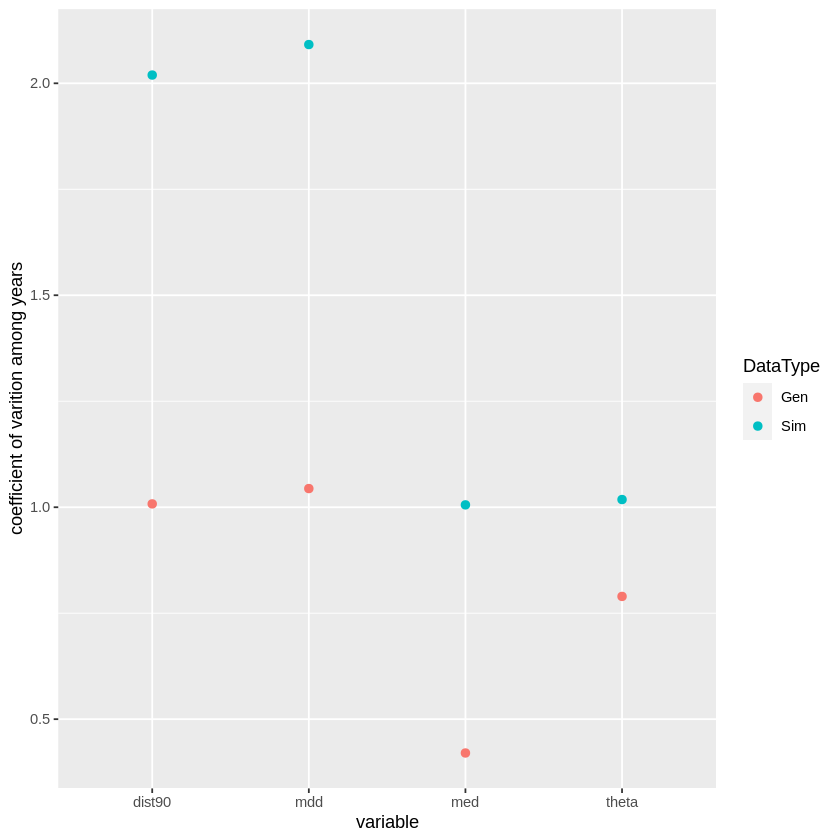

In [120]:
CVPlot <- ggplot(data=CompareCV, aes(x=variable, y=value, color=data_type)) +
    geom_point(size=2) +
    ylab("coefficient of varition among years") #+
   # ggtitle()
    #geom_point(aes(x=SimMDD, y=GenMDD), color="blue")
CVPlot
#ggsave(filename="SimulationGeneticFitsCVComparison.png", plot= CVPlot, path="~/oceanography/script_output/KernelFits/Plots/" )


In [ ]:
ggplot(data=SimKernelVar, aes(x=Adj, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_point(data=SimPlusGenFits, aes(x=Year, y=AvgSimMDD, shape=Adj), fill=NA, color="black", size=3) + 
    geom_point(data=SimPlusGenFits, aes(x=Year, y=GenMDD), fill="red", color="red") + # with all fits


In [77]:
head(CombinedSims)
#head(SimPlusGenFits %>% spread(metric, value))

Year,k,theta,mdd,med,dist90,iteration,Adj
2012,2.263923,0.2645823,47.647397,11.23,114.86,1,SurvNoRecentRec
2012,-2.751382,2.5443994,8.185826,7.23,16.34,2,SurvNoRecentRec
2012,-2.396769,1.2721366,8.291947,6.25,18.34,3,SurvNoRecentRec
2012,-2.770307,2.6547136,8.260620,7.34,16.40,4,SurvNoRecentRec
2012,-2.433092,1.3359269,8.226354,6.30,18.05,5,SurvNoRecentRec
2012,-2.241767,1.1622086,7.788861,5.70,17.49,6,SurvNoRecentRec


Warning message:
“Removed 80 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 80 rows containing non-finite values (stat_ydensity).”

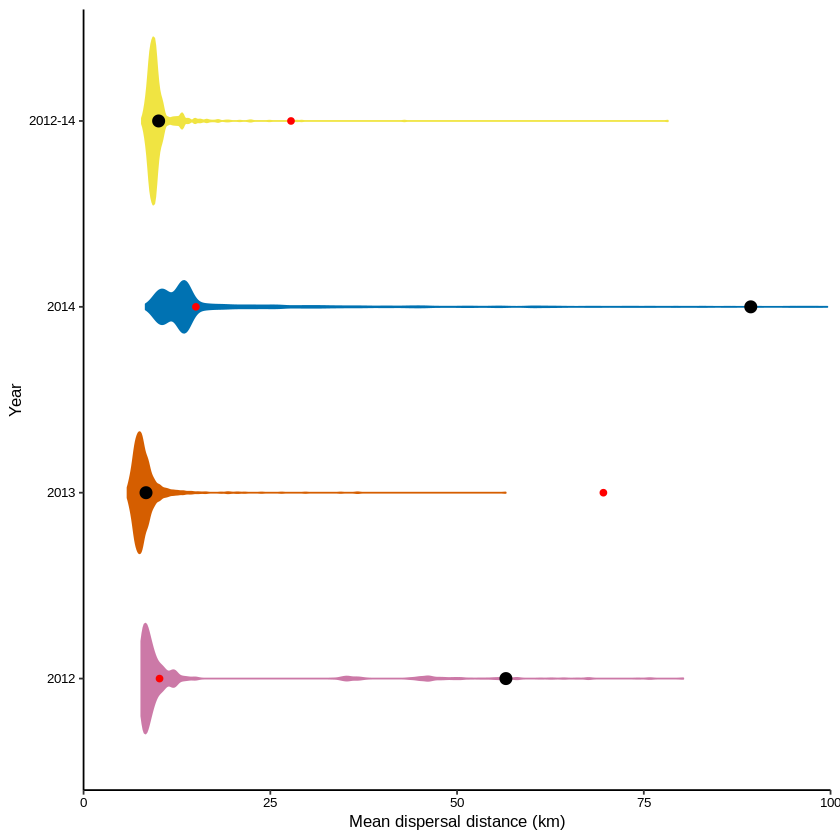

In [168]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

CombinedSims$Year <- factor(CombinedSims$Year, levels=c("2012", "2013", "2014", "2012-14"))
SimPlusGenFits$Year <- factor(SimPlusGenFits$Year, levels=c("2012", "2013", "2014", "2012-14"))
#PointsToPlot <- CompareFits %>% filter(Adj=="SurvNoRecentRec")
#PointsToPlot$Year <- factor(PointsToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))


mdd_violin <- ggplot(data=CombinedSims, aes(x=Year, y=mdd, color=Year, fill=Year), alpha=0.5) +
    geom_violin() +
    geom_point(data=PointsToPlot, aes(x=Year, y=SimMDD), fill=NA, color="black", size=3) + 
    geom_point(data=PointsToPlot, aes(x=Year, y=GenMDD), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 100), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev) +
    theme(legend.position = "none") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin 
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPointsSurvNoRecentRec.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


Warning message:
“Removed 344 rows containing non-finite values (stat_ydensity).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 344 rows containing non-finite values (stat_ydensity).”

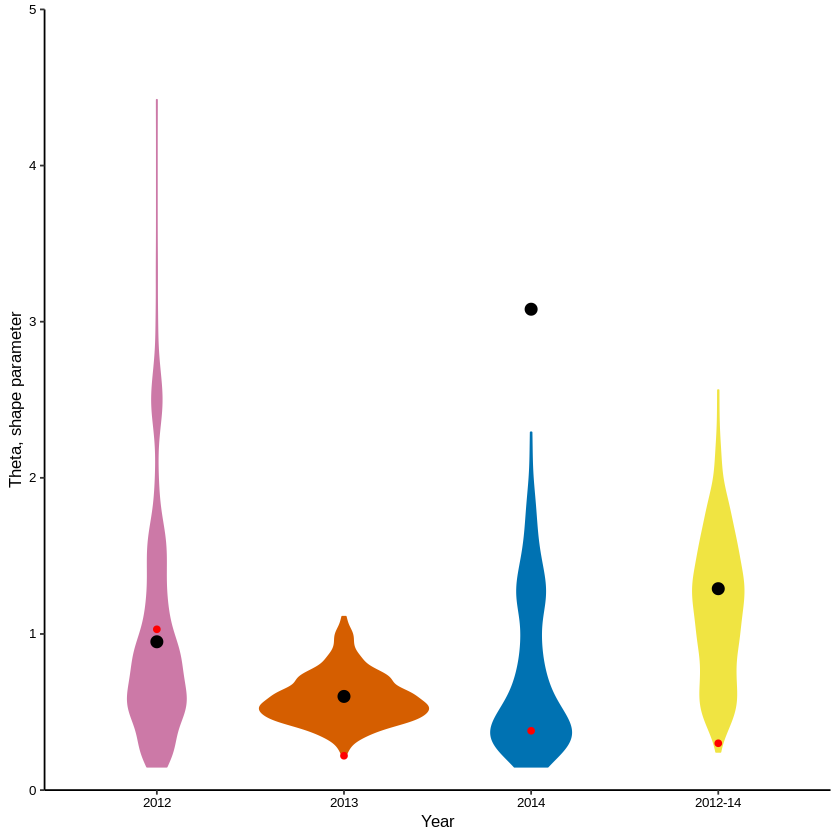

In [167]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

CombinedSims$year <- factor(CombinedSims$year, levels=c("2012", "2013", "2014", "2012-14"))
SimPlusGenFits$Year <- factor(SimPlusGenFits$Year, levels=c("2012", "2013", "2014", "2012-14"))
PointsToPlot <- CompareFits %>% filter(Adj=="SurvNoRecentRec")
PointsToPlot$Year <- factor(PointsToPlot$Year, levels=c("2012", "2013", "2014", "2012-14"))


theta_violin <- ggplot(data=CombinedSims %>% filter(Adj=="SurvNoRecentRec"), aes(x=year, y=theta, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    geom_point(data=PointsToPlot, aes(x=Year, y=SimTheta), fill=NA, color="black", size=3) + 
    geom_point(data=PointsToPlot, aes(x=Year, y=GenTheta), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
   # coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 5), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Theta, shape parameter") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev) +
    theme(legend.position = "none") 
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
theta_violin 
ggplot2::ggsave(filename="SimThetaPlusGenPointsSurvNoRecentRec.png",  plot=theta_violin, path="~/oceanography/script_output/KernelFits/Plots/")


In [154]:
str(PointsToPlot)

tibble [4 × 14] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ Year            : Factor w/ 4 levels "2012","2013",..: 1 4 2 3
 $ GenDist90       : num [1:4] 23.3 68.7 157.4 38.1
 $ GenK            : num [1:4] -2.36 1.68 4.04 0.49
 $ GenMDD          : num [1:4] 10.2 27.8 69.6 15
 $ GenMed          : num [1:4] 7.13 7.71 12.2 5.53
 $ GenTheta        : num [1:4] 1.03 0.3 0.22 0.38
 $ Adj             : chr [1:4] "SurvNoRecentRec" "SurvNoRecentRec" "SurvNoRecentRec" "SurvNoRecentRec"
 $ SimDist90       : num [1:4] 107.2 22.9 20.7 173.1
 $ SimK            : num [1:4] -1.11 -2.14 -0.61 -1.61
 $ SimMDD          : num [1:4] 56.54 10.05 8.36 89.32
 $ SimMed          : num [1:4] 9.67 6.86 4.14 16.66
 $ SimTheta        : num [1:4] 0.95 1.29 0.6 3.08
 $ MDDDiffGenVSim  : num [1:4] 46.4 17.7 61.2 74.3
 $ ThetaDiffGenVSim: num [1:4] 0.08 0.99 0.38 2.7
 - attr(*, "groups")= tibble [4 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ Year : Factor w/ 4 levels "2012","2013",..: 1 2 3 4
  ..$ .rows: list<int> [1:4] 
  ..

In [161]:
#read in the seasonal simulation kernel fits

#no adjustments
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T) %>%
    mutate(Adj="no")
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T) %>%
    mutate(Adj="no")

#adjusting for survival and growth
SimulatedKernelsNEMSurvGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEMSurvGrowth.csv", header=T) %>%
    mutate(Adj="SurvGrowth")
SimulatedKernelsSWMSurvGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWMSurvGrowth.csv", header=T) %>%
    mutate(Adj="SurvGrowth")

#adjusting for growth
SimulatedKernelsNEMGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEMGrowth.csv", header=T) %>%
    mutate(Adj="Growth")
SimulatedKernelsSWMGrowth <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWMGrowth.csv", header=T) %>%
    mutate(Adj="Growth")

CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM, SimulatedKernelsNEMSurvGrowth, SimulatedKernelsSWMSurvGrowth, SimulatedKernelsNEMGrowth, SimulatedKernelsSWMGrowth) %>%
    rename(Season="season") 

#empirical seasons for 2012-2014
SeasonalKernels2012_14 <- read.csv(file="~/oceanography/empirical_data/genetics/SeasonalGenKernelsForROMSComp.csv", header=T) %>%
    rename(Season="season",GenK="k", GenTheta="theta", GenMDD="mdd", GenMed="med", GenDist90="dist90") %>%
    mutate(GenK=round(GenK, digits=2)) %>%
    mutate(GenTheta=round(GenTheta, digits=2)) %>%
    mutate(GenMDD=round(GenMDD, digits=2)) %>%
    mutate(TimeFrame="2012-14")#%>%
    #mutate(JoinKey="all")


SeasonalKernels2012_18 <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T) %>%
    select(Season, best_k, best_theta, MeanDispersalDistance, MedianDispersalDistance, Dist90Retained) %>%    
    rename(GenK="best_k", GenTheta="best_theta", GenMDD="MeanDispersalDistance", GenMed="MedianDispersalDistance", GenDist90="Dist90Retained") %>%
    mutate(GenMDD=round(GenMDD, digits=2)) %>%
    mutate(TimeFrame="2012-18")#%>%
    #mutate(JoinKey="all")

GenSeasonalKernels <- bind_rows(SeasonalKernels2012_14, SeasonalKernels2012_18)

In [151]:
head(CombinedSeasons)

Season,k,theta,mdd,med,dist90,iteration,Adj
NEM,-2.49,1.30,8.94,6.78,19.71,1,no
NEM,0.85,0.34,21.84,7.14,55.00,2,no
NEM,-1.38,0.64,10.05,5.59,24.73,3,no
NEM,-2.06,0.91,9.06,6.05,21.17,4,no
NEM,-2.52,1.33,9.04,6.91,19.86,5,no
NEM,-1.92,0.84,9.04,5.82,21.40,6,no


In [162]:
AvgSeasonalKernels <- CombinedSeasons %>% 
    select(-iteration) %>%
    group_by(Season, Adj) %>%
    summarise_each(funs(mean)) %>%
    mutate(k=round(k, digits=2)) %>%
    mutate(theta=round(theta, digits=2)) %>%
    mutate(mdd=round(mdd, digits=2))%>%
    mutate(med=round(med, digits=2))%>%
    mutate(dist90=round(dist90, digits=2)) %>%
    rename(AvgSimK="k", AvgSimTheta="theta", AvgSimMDD="mdd", AvgSimMed="med", AvgSimDist90="dist90") %>%
    mutate(TimeFrame="2012-14")# %>%
    #mutate(JoinKey="all")

In [189]:
SimPlusGenFitsSeasons <- right_join(AvgSeasonalKernels, GenSeasonalKernels, by=c("Season", "TimeFrame"))%>%
    mutate(MDDDiffGenVSim=abs(GenMDD-AvgSimMDD)) %>%
    arrange(MDDDiffGenVSim) %>%
    mutate(GenK=round(GenK, digits=2)) %>%
    mutate(GenTheta=round(GenTheta, digits=2)) %>%
    mutate(GenMDD=round(GenMDD, digits=2))

SimPlusGenFitsSeasons %>%
    group_by(Season) %>%
    filter(MDDDiffGenVSim==min(MDDDiffGenVSim, na.rm=T))

SimPlusGenFitsSeasons

#write.csv(SimPlusGenFits, file="~/oceanography/script_output/KernelFits/SimPlusGenKernelFitsSeasons.csv", row.names=F)

Season,Adj,AvgSimK,AvgSimTheta,AvgSimMDD,AvgSimMed,AvgSimDist90,TimeFrame,GenK,GenTheta,GenMDD,GenMed,GenDist90,MDDDiffGenVSim
SWM,no,-2.45,1.39,8.58,6.57,18.77,2012-14,-1.62,0.76,8.34,5.1,20.07,0.24
NEM,SurvGrowth,-2.02,1.17,10.10,6.69,23.37,2012-14,6.95,0.15,2755.86,212.8,4810.04,2745.76


Season,Adj,AvgSimK,AvgSimTheta,AvgSimMDD,AvgSimMed,AvgSimDist90,TimeFrame,GenK,GenTheta,GenMDD,GenMed,GenDist90,MDDDiffGenVSim
SWM,no,-2.45,1.39,8.58,6.57,18.77,2012-14,-1.62,0.76,8.34,5.10,20.07,0.24
SWM,SurvGrowth,-2.44,1.37,8.63,6.59,18.94,2012-14,-1.62,0.76,8.34,5.10,20.07,0.29
SWM,Growth,-2.40,1.32,8.66,6.52,19.13,2012-14,-1.62,0.76,8.34,5.10,20.07,0.32
NEM,SurvGrowth,-2.02,1.17,10.10,6.69,23.37,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.76
NEM,Growth,-2.04,1.17,10.01,6.66,23.13,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.85
NEM,no,-2.08,1.26,9.95,6.72,22.82,2012-14,6.95,0.15,2755.86,212.80,4810.04,2745.91
SWM,NA,NA,NA,NA,NA,NA,2012-18,-2.60,1.58,8.57,6.87,18.32,NA
NEM,NA,NA,NA,NA,NA,NA,2012-18,-0.89,0.56,9.45,4.82,23.60,NA


Warning message:
“Removed 2 rows containing missing values (geom_point).”Saving 6.67 x 6.67 in image
Warning message:
“Removed 2 rows containing missing values (geom_point).”

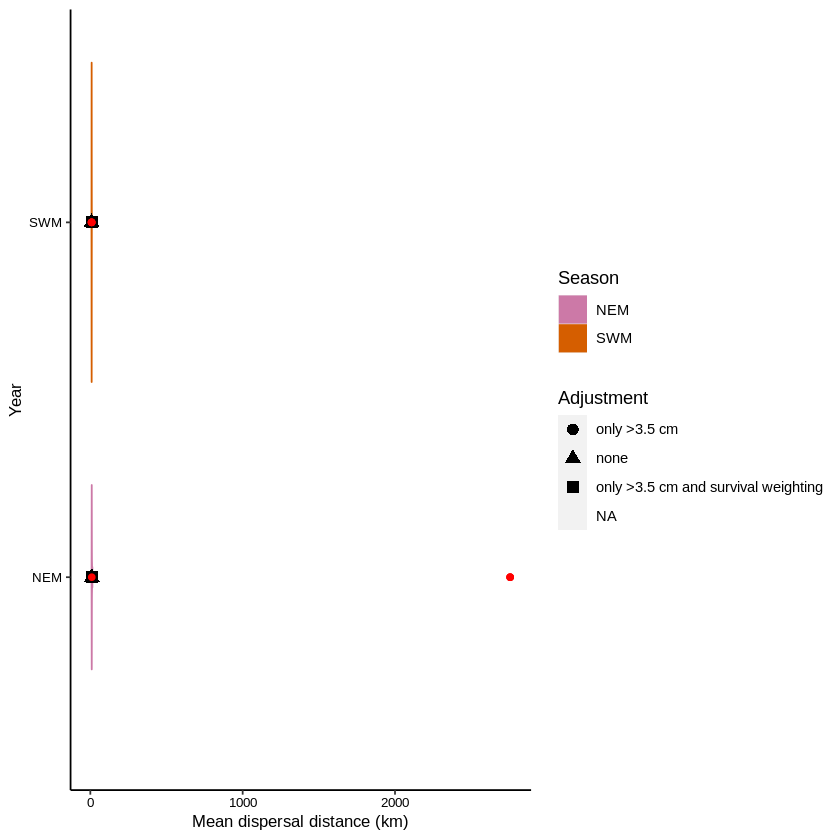

In [193]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

#CombinedSeasons$Season <- factor(CombinedSeasons$Season, levels=c("2012", "2013", "2014", "2012-14"))
#SimPlusGenFitsSeasons$Season <- factor(SimPlusGenFitsSeasons$Season, levels=c("2012", "2013", "2014", "2012-14"))

mdd_violin <- ggplot(data=CombinedSeasons, aes(x=Season, y=mdd, color=Season, fill=Season), alpha=0.5) +
    geom_violin() +
    geom_point(data=SimPlusGenFitsSeasons, aes(x=Season, y=AvgSimMDD, shape=Adj), fill=NA, color="black", size=3) + 
    geom_point(data=SimPlusGenFitsSeasons, aes(x=Season, y=GenMDD), fill="red", color="red") + # with all fits
    #geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    scale_shape_discrete(name = "Adjustment", labels = c("only >3.5 cm", "none", "only >3.5 cm and survival weighting"))+
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    #scale_y_continuous(limits = c(0, 30), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica")) + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPointsSeasons.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


In [192]:
cbbPalette <- c("#000000", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7")
cbbPalette_rev <- rev(cbbPalette)

mdd_violin <- ggplot(data=SimCombinedSummary, aes(x=year, y=mdd, color=year, fill=year), alpha=0.5) +
    geom_violin() +
    #geom_point(data=AverageFits2, aes(x=year, y=mdd), fill="snow",color="darkgray", shape=21) + #without borderline fits
    geom_point(data=AverageFits, aes(x=year, y=mdd), fill="black ",color="darkgray", shape=21) + # with all fits
    geom_point(data=kernels %>% filter(Year %in% c("2012", "2013", "2014", "all")), aes(x=Year, y=MeanDispDist), fill="black",color="darkgray", shape=24) + #genetic estimates
    coord_flip() +
    #scale_x_continuous(limits = c(0, 100), expand=c(0,0)) +
    scale_y_continuous(limits = c(0, 83), expand = c(0,0))+
    theme(panel.grid.major = element_blank(),
    plot.margin=unit(c(0.2,0.2,0.2,0.2),"cm"),
    panel.grid.minor = element_blank(), 
    panel.background = element_blank(), #,
    axis.line = element_line(colour = "black")) +
    xlab("Year") + 
    ylab("Mean dispersal distance (km)") +
    theme(axis.text.x = element_text(size=8, color="black", family="Helvetica"),#15 for publication, 20 for presentation #element_text(size=15, color="black", family="Helvetica"),
    axis.text.y =  element_text(size=8, color="black", family="Helvetica"),
    axis.title.y =  element_text(size=10, color="black", family="Helvetica"), 
    axis.title.x =  element_text(size=10, color="black", family="Helvetica"),    
    legend.position = "none") + 
    scale_colour_manual(values=cbbPalette_rev)+
    scale_fill_manual(values=cbbPalette_rev)
    #scale_y_continuous(breaks = 1:2000, labels = c(1:50,"break",1000:2000))
mdd_violin
ggplot2::ggsave(filename="SimMeanDispDistPlusGenPoints.png",  plot=mdd_violin, path="~/oceanography/script_output/KernelFits/Plots/")


ERROR: Error in ggplot(data = SimCombinedSummary, aes(x = year, y = mdd, color = year, : object 'SimCombinedSummary' not found


In [115]:
(SimPlusGenFits)

year,SimK,SimTheta,SimMDD,SimKurtosis,GenK,GenTheta,GenMDD,GenMedDispDist
2012,-1.828326,1.250510,10.127328,15.518027,-2.36,1.03,10.165094,7.13
2013,-1.242150,0.804757,8.091848,13.967938,4.04,0.22,69.586280,12.20
2014,-1.926596,1.243059,26.376964,86.415760,0.49,0.38,15.037515,5.53
all,-1.919426,1.014670,10.219857,8.635482,-2.51,1.49,8.153016,6.44


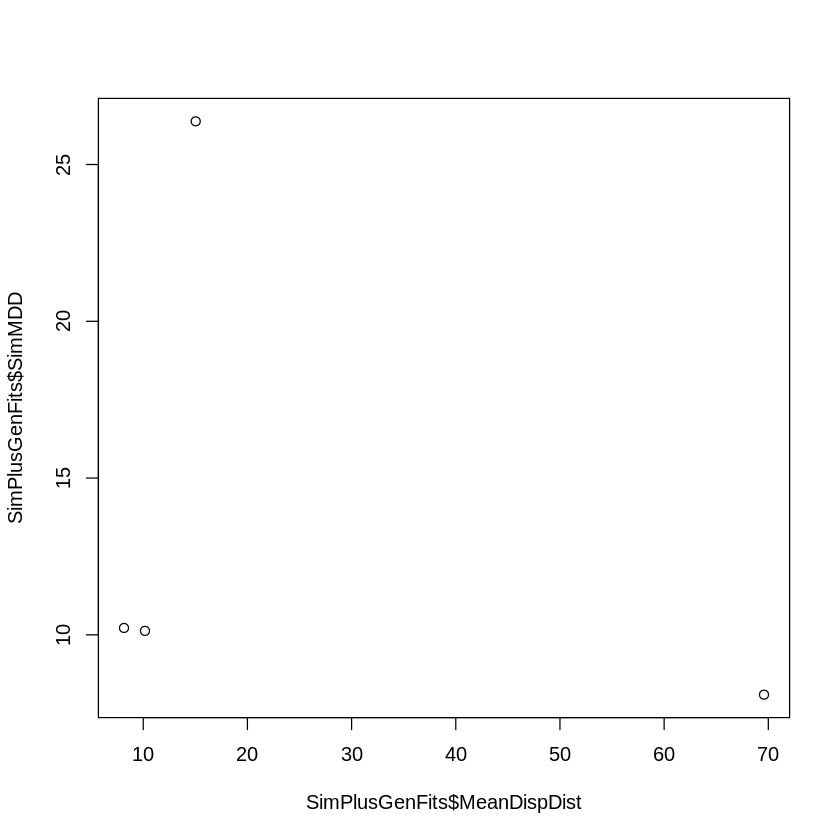

In [95]:
plot(SimPlusGenFits$SimMDD~SimPlusGenFits$MeanDispDist)

In [60]:
MDDAllYear <- CombinedSims %>% 
    filter(year=="all")
#pdf("~/oceanography/script_output/KernelFits/Plots/MeanDispDistHist2012-14.pdf")
hist(MDDAllYear$mdd, breaks=100, main=NULL, xlab="Mean dispersal distance (km)")
#dev.off()
summary(MDDAllYear$mdd)

Warning message in min(x):
“no non-missing arguments to min; returning Inf”Warning message in max(x):
“no non-missing arguments to max; returning -Inf”

ERROR: Error in hist.default(MDDAllYear$mdd, breaks = 100, main = NULL, xlab = "Mean dispersal distance (km)"): character(0)


In [97]:
#test for correlations
cor.test(SimPlusGenFits$SimMDD, SimPlusGenFits$MeanDispDist,  method = "pearson")
cor.test(SimPlusGenFits$SimTheta, SimPlusGenFits$GenTheta,  method = "pearson")



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimMDD and SimPlusGenFits$MeanDispDist
t = -0.53384, df = 2, p-value = 0.6468
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9812079  0.9202897
sample estimates:
       cor 
-0.3531582 



	Pearson's product-moment correlation

data:  SimPlusGenFits$SimTheta and SimPlusGenFits$GenTheta
t = 0.32913, df = 2, p-value = 0.7733
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.9389710  0.9752907
sample estimates:
      cor 
0.2266754 


In [17]:
#seasons
SimulatedKernelsNEM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsNEM.csv", header=T)
SimulatedKernelsSWM <-  read.csv(file="~/oceanography/script_output/KernelFits/100SimulatedKernelsSWM.csv", header=T)
CombinedSeasons <- bind_rows(SimulatedKernelsNEM, SimulatedKernelsSWM) %>%
    select(-iteration)

In [24]:
SeasonalKernels <- read.csv(file="~/parentage/kernel_fitting/1340_loci/final_results/tables/RecruitSizeAsSeasonlity_summary.csv", header=T)
head(SeasonalKernels)

Season,RecruitSizeAtSampling,best_k,best_theta,k_CI95_lower,k_CI95_upper,theta_CI95_lower,theta_CI95_upper,MeanDispersalDistance,MeanDispDist_CI95_lower,MeanDispDist_CI95_upper,MedianDispersalDistance,MedianDispDist_CI95_lower,MedianDispDist_CI95_upper,Dist90Retained
SWM,> 4.5 cm,-2.60,1.58,-2.63,-2.47,1.34,1.59,8.574871,7.132250,10.39623,6.87,4.93,9.28,18.32
NEM,< 3.5 cm,-0.89,0.56,-1.46,-0.74,0.54,0.61,9.446898,6.014163,4272.46841,4.82,3.24,323.37,23.60
